# Auto Insurance Policy Lapse Risk Prediction

### Author: Henry Udeogu

This machine learning project uses real-world, insurance-aligned dataset from the paper
`"Dataset of an actual motor vehicle insurance portfolio" by Segura-Gisbert et al.` The authors of this paper conducted a research project within a Spanish insurance company and gained access to a sample of their motor vehicle insurance portfolio datasets which they were also authorized to share. This dataset is a collection of **105,555 records**, and the data has been anonymized to protect the policyholders' identities.

This dataset includes indispensable date-related information, including the effective date of policies, the birthdates of insured individuals, and renewal dates. It also enriched with valuable economic variables, notably premiums and claim costs. 

It is important to mention that the availability of open access data concerning insured populations is currently limited. This dataset can be used by insurance companies, researchers and educators and is relevant for marketing purposes; including customer segmentation, contract renewal processes, price renewal strategies, optimization and price sensitivity models, as well as pricing mechanisms for new business.

The **primary goal** of this project is to build a classification model that predicts whether a customer is likely to let their auto insurance policy lapse (i.e., churn), so retention campaigns can be better targeted.

<u>**Impact:**</u>
-  **Improve Policyholder Retention** – Identify customers at risk of lapsing and implement proactive engagement strategies.
- **Optimize Marketing & Outreach** – Personalize communication strategies based on predicted lapse risk scores.
- **Reduce Revenue Losses** – Mitigate potential revenue decline due to policyholder churn.

*<u>Data Source:</u> The dataset was collected from a non-life insurance company operating in Spain; therefore, the data has been meticulously anonymized to align with the prevailing European legislation, safeguarding individual privacy and confidentiality. For ease of use, the authors have cleaned the data and provided a clean data file in spreadsheet format and can be accessed via the DOI link below.*
https://doi.org/10.17632/5cxyb5fp4f.2

In [2]:
from IPython.display import display, HTML, display_html

# Widen notebook cells
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
np.bool = bool  # compatibility patch for SHAP
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import missingno as msno
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

# Import undersampling & oversampling libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE

from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

import streamlit as st
import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [3]:
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Load Dataset & Overview of the Data

The dataset is formatted as a spreadsheet covering the main operations of the company during a period of three (3) full years (**November 2015 to December 2018**), containing several motor insurance portfolio variables. This dataset comprises **105,555 rows** and **32 columns**. Each row signifies a policy transaction, while each column represents a distinct variable.

There are three (3) files in the data/raw folder:
- `Descriptive of the variables.xlsx` : Description of the variables in the dataset
- `Motor vehicle insurance data.csv` : Full motor insurance dataset (105K+ rows, 30 columns)
- `sample type claim.csv` : Partial claim type data (only 15% of policies, 2 additional columns relating to  "claim_type")

All dataset files have been included in the github repo for this project and the description of the variables and the raw variables can be viewed in the spreadsheets. https://github.com/HenryUdeogu/insurance-policy-lapse-prediction/tree/main/data/raw

### Categorizing the Variables

Based on the description of the raw variables, I have categorized them under 5 Features sets.

1. **Customer Demographics** - Describe's the policyholder’s personal background, such as Age, Gender, Income Level etc.
2. **Policy Details** - Describes the structure and lifecycle of the insurance policy, including tenure, renewal dates, and claims history.
3. **Policy Behaviour/Enagagement** - Describes policyholder's relationship history with the insurer. E.g. payment method, products held & lapse records.
4. **Financial Metrics** - Describes variables reflecting the economic value of the policy. This includes premiums paid and claim costs.
5. **Vehicle & Driving History** - Describes the technical and historical data about the insured vehicle and driving characteristics.

| No | Category | Raw Variable(s) | ML Feature Idea |
| :- | :- | -: | :-: |
| 1. | Customer Demographics | `ID`, `Date_birth` | Age of policyholder may impact lapse
| 2. | Policy Details | `Seniority`, `N_claims_year`, `N_claims_history`, `R_Claims_history`, `Date_start_contract`, `Date_last_renewal`, `Date_next_renewal`, `Date_lapse` | Longer tenure may reduce lapse risk, Claims frequency impact on satisfaction
| 3. | Policy Behavior & Engagment | `Distribution_channel`, `Payment`, `Policies_in_force`, `Max_policies`, `Max_products`, `Lapse` | Indicator of loyalty and cross-sell opportunity, Annual vs semi-annual payment method (may affect lapse), Broker vs agent — can impact retention, More bundled products may indicate higher retention
| 4. | Financial Metrics | `Premium`, `Cost_claims_year` | High premiums + no claims = dissatisfaction risk
| 5. | Vehicle & Driving History | `Date_driving_licence`, `Type_risk`, `Power`, `Cylinder_capacity`, `Value_vehicle`, `Year_matriculation`, `N_doors`, `Type_fuel`, `Length`, `Weight`, `Area`, `Second_driver` | High-value or risky vehicles may correlate with lapse, Urban vs Rural may affect churn behavior, Driving Experience may impact lapse


While the dataset `Motor vehicle insurance data.csv` is detailed, some variables, such as the number and cost of claims are aggregated, limiting insight. Separating the claims by type adds significant value. 


### Claim Type Data

The dataset `sample type claim.csv` holds more granular information for a sample of policies. Unfortunately, the Insurance Company provided only 15% of the claim type data because they considered the full set too sensitive, as it could expose the risk structure and proprietary pricing models.

Even with this constraint, I believe that including `claim types` and `cost by type` variables in my final feature set will help in determining the composition of some of the most significant risk variables while adding domain-specific richness to this insurance_policy_lapse_model.

I will also add new features which will be engineered using the `claim types` and `cost by type`.

In [4]:
# Load 'main' & 'sample type claim' datasets
df_main = pd.read_csv("data/raw/Motor vehicle insurance data.csv")

df_claims = pd.read_csv("data/raw/sample type claim.csv")

# Create a pivot table of the claims data to have a dataframe with each row for each policyholder and columns with the claim type and cost
df_claims_pivot = df_claims.pivot_table(
    index="ID",
    columns="Claims_type",
    values="Cost_claims_by_type",
    aggfunc="sum",
    fill_value=0)

In [5]:
df_main.head()

ID Date_start_contract Date_last_renewal Date_next_renewal  Date_birth  \
0   1           5/11/2015         5/11/2015         5/11/2016  15/04/1956   
1   1           5/11/2015         5/11/2016         5/11/2017  15/04/1956   
2   1           5/11/2015         5/11/2017         5/11/2018  15/04/1956   
3   1           5/11/2015         5/11/2018         5/11/2019  15/04/1956   
4   2          26/09/2017        26/09/2017        26/09/2018  15/04/1956   

  Date_driving_licence  Distribution_channel  Seniority  Policies_in_force  \
0           20/03/1976                     0          4                  1   
1           20/03/1976                     0          4                  1   
2           20/03/1976                     0          4                  2   
3           20/03/1976                     0          4                  2   
4           20/03/1976                     0          4                  2   

   Max_policies  Max_products  Lapse Date_lapse  Payment  Premium  \
0             2             1      0        NaN        0   222.52   
1             2             1      0        NaN        0   213.78   
2             2             1      0        NaN        0   214.84   
3             2             1      0        NaN        0   216.99   
4             2             1      0        NaN        1   213.70   

   Cost_claims_year  N_claims_year  N_claims_history  R_Claims_history  \
0               0.0              0                 0               0.0   
1               0.0              0                 0               0.0   
2               0.0              0                 0               0.0   
3               0.0              0                 0               0.0   
4               0.0              0                 0               0.0   

   Type_risk  Area  Second_driver  Year_matriculation  Power  \
0          1     0              0                2004     80   
1          1     0              0                2004     80   
2          1     0              0                2004     80   
3          1     0              0                2004     80   
4          1     0              0                2004     80   

   Cylinder_capacity  Value_vehicle  N_doors Type_fuel  Length  Weight  
0                599         7068.0        0         P     NaN     190  
1                599         7068.0        0         P     NaN     190  
2                599         7068.0        0         P     NaN     190  
3                599         7068.0        0         P     NaN     190  
4                599         7068.0        0         P     NaN     190

In [6]:
df_main['Type_risk'].unique()

array([1, 3, 2, 4])

In [7]:
print(f" Number of records in 'main_dataset' is : {len(df_main)}")
print(f" Number of policyholders (i.e. unique policy IDs) in 'main_dataset' : {df_main['ID'].nunique()}")

 Number of records in 'main_dataset' is : 105555
 Number of policyholders (i.e. unique policy IDs) in 'main_dataset' : 53502


In [8]:
df_claims.head()

ID  Cost_claims_year  Cost_claims_by_type        Claims_type
0  28            332.02               332.02          complaint
1  36             57.35                57.35  travel assistance
2  42             57.50                57.50  travel assistance
3  60            138.90                67.25  travel assistance
4  60            138.90                71.65  travel assistance

In [9]:
df_claims_pivot.head()

Claims_type  all risks  broken windows  complaint  fire  injuries  negligence  \
ID                                                                              
28                 0.0             0.0     332.02   0.0       0.0         0.0   
36                 0.0             0.0       0.00   0.0       0.0         0.0   
42                 0.0             0.0       0.00   0.0       0.0         0.0   
60                 0.0             0.0       0.00   0.0       0.0         0.0   
77                 0.0             0.0    1574.93   0.0       0.0         0.0   

Claims_type  other  theft  travel assistance  
ID                                            
28             0.0    0.0               0.00  
36             0.0    0.0              57.35  
42             0.0    0.0              57.50  
60             0.0    0.0             138.90  
77             0.0    0.0               0.00

In [10]:
print(f" Number of records in 'sample type claim dataset' is : {len(df_claims)}")
print(f" Number of policyholders (i.e. unique policy IDs) in 'sample type claim dataset' : {df_claims['ID'].nunique()}")

 Number of records in 'sample type claim dataset' is : 7366
 Number of policyholders (i.e. unique policy IDs) in 'sample type claim dataset' : 5255


### Print missing values & data type per column

In [11]:
print("\nMissing values & data type in main_dataset.csv:\n")
main_dataset = pd.DataFrame(df_main.isnull().sum(), columns=['Missing Values'])
main_dataset['Data Type'] = df_main.dtypes
main_dataset


Missing values & data type in main_dataset.csv:



Missing Values Data Type
ID                                 0     int64
Date_start_contract                0    object
Date_last_renewal                  0    object
Date_next_renewal                  0    object
Date_birth                         0    object
Date_driving_licence               0    object
Distribution_channel               0     int64
Seniority                          0     int64
Policies_in_force                  0     int64
Max_policies                       0     int64
Max_products                       0     int64
Lapse                              0     int64
Date_lapse                     70408    object
Payment                            0     int64
Premium                            0   float64
Cost_claims_year                   0   float64
N_claims_year                      0     int64
N_claims_history                   0     int64
R_Claims_history                   0   float64
Type_risk                          0     int64
Area                               0     int64
Second_driver                      0     int64
Year_matriculation                 0     int64
Power                              0     int64
Cylinder_capacity                  0     int64
Value_vehicle                      0   float64
N_doors                            0     int64
Type_fuel                       1764    object
Length                         10329   float64
Weight                             0     int64

In [12]:
print("\nMissing values & data type in sample type claim.csv:\n")
sample_claim_dataset = pd.DataFrame(df_claims_pivot.isnull().sum(), columns=['Missing Values'])
sample_claim_dataset['Data Type'] = df_claims_pivot.dtypes
sample_claim_dataset


Missing values & data type in sample type claim.csv:



Missing Values Data Type
Claims_type                                
all risks                       0   float64
broken windows                  0   float64
complaint                       0   float64
fire                            0   float64
injuries                        0   float64
negligence                      0   float64
other                           0   float64
theft                           0   float64
travel assistance               0   float64

## Data Preprocessing & Feature Engineering

### Why 2020?
Because the dataset covers policies and claims up to 2018, and the dataset was extracted in 2019 (as per the paper), using "2020-01-01" provides a stable and consistent reference point that:

Follows the last complete year of data (2018)

Aligns with the report’s modeling horizon

Allows you to calculate age and experience at the likely point of model evaluation or policy decision

### Claim_type Feature -- Update

The final column corresponds to the variable , which informs about the type of claim linked to the amount detailed in . We have identified up to nine types of claims in the subset. Travel assistance and broken windows are the claims with the smallest amounts of money, causing the least damage to the vehicle. The category complaint means that the insured driver is innocent and is seeking compensation for damages from a third party. The option negligence means that the insured driver is at fault in the accident, such as by hitting another vehicle. There are also classic claims such as theft and fire, with fire having one of the highest average amounts in the sample. Another category includes all risks that means insured person’s own damages are compensated, minus any applicable deductibles. The injuries category refers to damage caused to occupants and represents the type of claim with the highest average amount. Lastly, there is a diverse category, although much less frequent, labelled as other, which includes various types of claims, such as those caused by hitting animals.

In [13]:
def preprocess_data(df_main, df_claims_pivot):
    
    #1. === Convert date variables to Datetime fromat ===

    df_main['Date_start_contract'] = pd.to_datetime(df_main['Date_start_contract'], dayfirst=True)
    df_main['Date_last_renewal'] = pd.to_datetime(df_main['Date_last_renewal'], dayfirst=True)
    df_main['Date_next_renewal'] = pd.to_datetime(df_main['Date_next_renewal'], dayfirst=True)
    df_main['Date_birth'] = pd.to_datetime(df_main['Date_birth'], dayfirst=True)
    df_main['Date_driving_licence'] = pd.to_datetime(df_main['Date_driving_licence'], dayfirst=True)
    df_main['Date_lapse'] = pd.to_datetime(df_main['Date_lapse'], dayfirst=True)
    
    
    #2. === Convert Date variables to "Age", rename variables, convert "N_claims_year", "Type_fuel", "Type_risk" variables to categorical, using certain thresholds  ===
    
    # Because the dataset covers policies and claims up to 2018, and the dataset was extracted in 2019 
    #(as per the paper), using "2020-01-01" provides a stable and consistent reference.
    proposed_date = "2020-01-01"


    df_main['CustomerAge'] = pd.to_datetime(proposed_date) - pd.to_datetime(df_main['Date_birth'], dayfirst=True)
    df_main['CustomerAge'] = df_main['CustomerAge'].dt.days // 365

    df_main['DrivingExperienceYears'] = pd.to_datetime(proposed_date) - pd.to_datetime(df_main['Date_driving_licence'], dayfirst=True)
    df_main['DrivingExperienceYears'] = df_main['DrivingExperienceYears'].dt.days // 365

    df_main['VehicleAge'] = pd.to_datetime(proposed_date).year - df_main['Year_matriculation']


    df_main.rename(columns={'Seniority': 'TenureYears', 'Policies_in_force': 'TotalPoliciesHeld',
                            'Premium': 'PremiumAmount', 'R_Claims_history': 'ClaimsFrequency',
                            'Second_driver': 'MultipleDriversFlag', 'Area': 'IsUrban', 'Length': 'Length_vehicle',
                            'Weight': 'Weight_vehicle', 'Power': 'Power_vehicle','N_doors': 'N_doors_vehicle',
                            'Cylinder_capacity': 'Cylinder_capacity_vehicle', 
                            'Cost_claims_year': 'Total_Cost_claims_year'},inplace=True)

    df_main['HasClaimsThisYear'] = df_main['N_claims_year'].apply(lambda x: 1 if x > 0 else 0) # If the policyholder has at least 1 claim already that year 1, else 0
    df_main['FuelTypeDiesel'] = df_main['Type_fuel'].apply(lambda x: 1 if x == 'D' else 0 if x == 'P' else x) #If Type_fuel used is Diesel 1, else 0
    df_main['Type_risk'] = df_main['Type_risk'].apply(lambda x: 1 if x == 3 else 0) # If Passenger Car 1, else 0
    
    
    #3. === Create a variable called "LapsePriorYear". This variable is categorical and indicates is a policyholder had a lapse in the year 1 or not 0 ===
    
    # Create temp table with policy year and lapse info in that year
    temp = df_main[['ID', 'Date_last_renewal', 'Date_next_renewal', 'Lapse']]
    
    # Get 1 year prior to current policy year
    df_main['Date_last_renewal_priorYear'] = df_main['Date_last_renewal'] - pd.DateOffset(years=1)
    df_main['Date_next_renewal_priorYear'] = df_main['Date_next_renewal'] - pd.DateOffset(years=1)

    # Join temp with original data to add "Lapse" information from previous year
    df_main = pd.merge(df_main, temp, left_on=['ID','Date_last_renewal_priorYear', 'Date_next_renewal_priorYear']
                           , right_on=['ID', 'Date_last_renewal', 'Date_next_renewal'], how = 'left')

    # Rename columns after join
    df_main.rename(columns={'Date_last_renewal_x': 'Date_last_renewal', 
                                'Date_next_renewal_x': 'Date_next_renewal', 'Lapse_x': 'Lapse',
                                'Lapse_y': 'LapsedPriorYear'}, inplace=True)

    # Drop columns not needed after join
    df_main.drop(['Date_last_renewal_priorYear', 'Date_next_renewal_priorYear', 'Date_last_renewal_y',
                      'Date_next_renewal_y'], axis=1, inplace=True)

    # Fill Empty values of 'LapsedPriorYear' with 0. No indicates no lapse in past year
    df_main['LapsedPriorYear'] = df_main['LapsedPriorYear'].fillna(0)
    df_main['LapsedPriorYear'] = df_main['LapsedPriorYear'].apply(lambda x: 1 if x > 0 else 0)
    df_main['LapsedPriorYear'] = df_main['LapsedPriorYear'].astype('int64')
    
    
    #4. === Drop columns not needed. Mostly date variables, including the "Date_lapse" variable ===
    
    ## -- Justification for dropping "Date_lapse" variable --
    # Records without 'Date_lapse' information
    df_main_wt_date_lapse = df_main['Date_lapse'].isnull().sum()

    # Percentage of records without 'Date_lapse' information
    df_main_wt_date_lapse_pct = (df_main_wt_date_lapse/len(df_main)) * 100
    print("Why drop Date_lapse?")
    print("% of Records without 'Date_lapse' information is: {:.1f}%".format(df_main_wt_date_lapse_pct))

    # Policyholders without 'Date_lapse' information. (Data_lapse_present = 0)
    ID_wt_date_lapse = df_main.groupby('ID').agg(Date_lapse_present=('Date_lapse', 'nunique'),
                                 Date_lapse=('Date_lapse', 'unique'))
    # Percentage of policyholders without 'Date_lapse' information
    ID_wt_date_lapse_pct = (ID_wt_date_lapse['Date_lapse_present'].sum()/len(ID_wt_date_lapse)) * 100
    print("% of Policyholders without 'Date_lapse' information is: {:.1f}%".format(100 - ID_wt_date_lapse_pct))

    # Dropping columns
    columns_to_drop = ['Date_birth', 'Date_driving_licence', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Year_matriculation', 'Date_lapse', 'N_claims_year', 'Type_fuel']
    df_main.drop(columns_to_drop, axis=1, inplace=True)
    
    print("\nVariables dropped: ", columns_to_drop)
    
    
    #5. === Rename Claims type dataset variables ===
    
    df_claims_pivot.columns = [f"Cost_{col}" for col in df_claims_pivot.columns]
    df_claims_pivot.reset_index(inplace=True)
    df_claims_pivot.rename(columns={'Cost_broken windows': 'Cost_broken_windows', 
                                    'Cost_travel assistance': 'Cost_travel_assistance',
                                    'Cost_all risks': 'Cost_all_risks'}, inplace=True)

    # Add "Claim_type_info_available flag" to help the model interpret missing claim-type info in 85% of rows.
    df_claims_pivot['Claim_type_info_available'] = 1
    
    
    #6. === Join Claims dataset to Main dataset ===

    #To ensure I am only joining to the main dataset to match year when the policyholder had a claim
    df_claims_pivot['HasClaimsThisYear'] = 1

    df_enriched = df_main.merge(df_claims_pivot, on=["ID", "HasClaimsThisYear"], how="left") # Merge Cost Type features with main

    cost_cols = [col for col in df_enriched.columns if col.startswith("Cost_")] # Make list of all Cost_type col
    df_enriched[cost_cols] = df_enriched[cost_cols].fillna(0) # Fill Cost columns "nan" values with 0 

    df_enriched['Claim_type_info_available'] = df_enriched['Claim_type_info_available'].fillna(0) #fill na in claim_type_info
    df_enriched['Claim_type_info_available'] = df_enriched['Claim_type_info_available'].astype('int64')
    
    
    #7. === Feature Engineering: Claim Type Features ===
    # Binary flags for key claims
    df_enriched['Has_injuries_claim'] = df_enriched['Cost_injuries'].apply(lambda x: 1 if x > 0 else 0)
    df_enriched['Has_fire_claim'] = df_enriched['Cost_fire'].apply(lambda x: 1 if x > 0 else 0)
    df_enriched['Has_theft_claim'] = df_enriched['Cost_theft'].apply(lambda x: 1 if x > 0 else 0)
    df_enriched['Has_broken_window_claim'] = df_enriched['Cost_broken_windows'].apply(lambda x: 1 if x > 0 else 0)
    df_enriched['Has_negligence_claim'] = df_enriched['Cost_negligence'].apply(lambda x: 1 if x > 0 else 0)
    df_enriched['Has_travel_assistance_claim'] = df_enriched['Cost_travel_assistance'].apply(lambda x: 1 if x > 0 else 0)

    # Minor claim indicator (e.g., only minor claims like glass, negligence, travel_assistance)
    minor_types = ['Cost_broken_windows', 'Cost_travel_assistance']
    df_enriched['Has_minor_claim'] = df_enriched[minor_types].fillna(0).gt(0).any(axis=1).astype(int)

    # Major claim indicator (e.g., injury, fire, theft, negligence)
    major_types = ['Cost_injuries', 'Cost_fire', 'Cost_theft', 'Cost_negligence']
    df_enriched['Has_major_claim'] = df_enriched[major_types].fillna(0).gt(0).any(axis=1).astype(int)

    # Cost of High Severity Claims "fire" + "injuries" + "theft" + "negligence"
    df_enriched['HighSeverityClaimCost'] = df_enriched['Cost_injuries'] + df_enriched['Cost_fire'] + df_enriched['Cost_theft'] + df_enriched['Cost_negligence']

    # Distinct claim types filed
    df_enriched['DistinctClaimTypesFiled'] = df_enriched[cost_cols].gt(0).sum(axis=1)
    
    df_enriched = df_enriched.drop(['ID'], axis=1) #No need for Unique policy ID anymore
    df_enriched['Lapse'] = df_enriched['Lapse'].apply(lambda x: 1 if x > 0 else 0) # Convert target to Categorical
    
    return df_enriched

In [14]:
df_enriched = preprocess_data(df_main, df_claims_pivot)

Why drop Date_lapse?
% of Records without 'Date_lapse' information is: 66.7%
% of Policyholders without 'Date_lapse' information is: 62.3%

Variables dropped:  ['Date_birth', 'Date_driving_licence', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Year_matriculation', 'Date_lapse', 'N_claims_year', 'Type_fuel']


In [15]:
df_enriched.head()

Distribution_channel  TenureYears  TotalPoliciesHeld  Max_policies  \
0                     0            4                  1             2   
1                     0            4                  1             2   
2                     0            4                  2             2   
3                     0            4                  2             2   
4                     0            4                  2             2   

   Max_products  Lapse  Payment  PremiumAmount  Total_Cost_claims_year  \
0             1      0        0         222.52                     0.0   
1             1      0        0         213.78                     0.0   
2             1      0        0         214.84                     0.0   
3             1      0        0         216.99                     0.0   
4             1      0        1         213.70                     0.0   

   N_claims_history  ClaimsFrequency  Type_risk  IsUrban  MultipleDriversFlag  \
0                 0              0.0          0        0                    0   
1                 0              0.0          0        0                    0   
2                 0              0.0          0        0                    0   
3                 0              0.0          0        0                    0   
4                 0              0.0          0        0                    0   

   Power_vehicle  Cylinder_capacity_vehicle  Value_vehicle  N_doors_vehicle  \
0             80                        599         7068.0                0   
1             80                        599         7068.0                0   
2             80                        599         7068.0                0   
3             80                        599         7068.0                0   
4             80                        599         7068.0                0   

   Length_vehicle  Weight_vehicle  CustomerAge  DrivingExperienceYears  \
0             NaN             190           63                      43   
1             NaN             190           63                      43   
2             NaN             190           63                      43   
3             NaN             190           63                      43   
4             NaN             190           63                      43   

   VehicleAge  HasClaimsThisYear  FuelTypeDiesel  LapsedPriorYear  \
0          16                  0             0.0                0   
1          16                  0             0.0                0   
2          16                  0             0.0                0   
3          16                  0             0.0                0   
4          16                  0             0.0                0   

   Cost_all_risks  Cost_broken_windows  Cost_complaint  Cost_fire  \
0             0.0                  0.0             0.0        0.0   
1             0.0                  0.0             0.0        0.0   
2             0.0                  0.0             0.0        0.0   
3             0.0                  0.0             0.0        0.0   
4             0.0                  0.0             0.0        0.0   

   Cost_injuries  Cost_negligence  Cost_other  Cost_theft  \
0            0.0              0.0         0.0         0.0   
1            0.0              0.0         0.0         0.0   
2            0.0              0.0         0.0         0.0   
3            0.0              0.0         0.0         0.0   
4            0.0              0.0         0.0         0.0   

   Cost_travel_assistance  Claim_type_info_available  Has_injuries_claim  \
0                     0.0                          0                   0   
1                     0.0                          0                   0   
2                     0.0                          0                   0   
3                     0.0                          0                   0   
4                     0.0                          0                   0   

   Has_fire_claim  Has_theft_claim  Has_broken_window_clai

### KNN Imputation for missing data in "Length" & "FuelTypeDiesel"

In [16]:
def kNN_imputer(df_enriched):
    # Create KNNImputer instance with 5 nearest neighbors
    imputer = KNNImputer(n_neighbors=5)
    kNN_imputed = imputer.fit_transform(df_enriched)
    kNN_imputed_df = pd.DataFrame(kNN_imputed, columns=df_enriched.columns, index=df_enriched.index)


    #Convert the columns back to their original data type after KNN Imputer (Converts to float datatype)
    ## Data Type table of the columns before imputation
    columns_df = pd.DataFrame(df_enriched.dtypes, columns=['data_type'])

    for index in columns_df.index:
        kNN_imputed_df[index] = kNN_imputed_df[index].astype(columns_df['data_type'].loc[index])

    kNN_imputed_df['FuelTypeDiesel'] = kNN_imputed_df['FuelTypeDiesel'].astype('int64') #Convert FuelTypeDiesel to int type from float
    
    return kNN_imputed_df

In [17]:
%%time
df_enriched_knn = kNN_imputer(df_enriched)

CPU times: user 1min 4s, sys: 51.4 s, total: 1min 55s
Wall time: 52 s


In [18]:
df_enriched_knn.head()

Distribution_channel  TenureYears  TotalPoliciesHeld  Max_policies  \
0                     0            4                  1             2   
1                     0            4                  1             2   
2                     0            4                  2             2   
3                     0            4                  2             2   
4                     0            4                  2             2   

   Max_products  Lapse  Payment  PremiumAmount  Total_Cost_claims_year  \
0             1      0        0         222.52                     0.0   
1             1      0        0         213.78                     0.0   
2             1      0        0         214.84                     0.0   
3             1      0        0         216.99                     0.0   
4             1      0        1         213.70                     0.0   

   N_claims_history  ClaimsFrequency  Type_risk  IsUrban  MultipleDriversFlag  \
0                 0              0.0          0        0                    0   
1                 0              0.0          0        0                    0   
2                 0              0.0          0        0                    0   
3                 0              0.0          0        0                    0   
4                 0              0.0          0        0                    0   

   Power_vehicle  Cylinder_capacity_vehicle  Value_vehicle  N_doors_vehicle  \
0             80                        599         7068.0                0   
1             80                        599         7068.0                0   
2             80                        599         7068.0                0   
3             80                        599         7068.0                0   
4             80                        599         7068.0                0   

   Length_vehicle  Weight_vehicle  CustomerAge  DrivingExperienceYears  \
0           3.495             190           63                      43   
1           3.495             190           63                      43   
2           3.495             190           63                      43   
3           3.495             190           63                      43   
4           3.495             190           63                      43   

   VehicleAge  HasClaimsThisYear  FuelTypeDiesel  LapsedPriorYear  \
0          16                  0               0                0   
1          16                  0               0                0   
2          16                  0               0                0   
3          16                  0               0                0   
4          16                  0               0                0   

   Cost_all_risks  Cost_broken_windows  Cost_complaint  Cost_fire  \
0             0.0                  0.0             0.0        0.0   
1             0.0                  0.0             0.0        0.0   
2             0.0                  0.0             0.0        0.0   
3             0.0                  0.0             0.0        0.0   
4             0.0                  0.0             0.0        0.0   

   Cost_injuries  Cost_negligence  Cost_other  Cost_theft  \
0            0.0              0.0         0.0         0.0   
1            0.0              0.0         0.0         0.0   
2            0.0              0.0         0.0         0.0   
3            0.0              0.0         0.0         0.0   
4            0.0              0.0         0.0         0.0   

   Cost_travel_assistance  Claim_type_info_available  Has_injuries_claim  \
0                     0.0                          0                   0   
1                     0.0                          0                   0   
2                     0.0                          0                   0   
3                     0.0                          0                   0   
4                     0.0                          0                   0   

   Has_fire_claim  Has_theft_claim  Has_broken_window_clai

In [19]:
# Print missing values per column
print("\nMissing values in dataset after applying KNN Imputation to fill in missing values in 'Length_vehicle' & 'FuelTypeDiesel' :\n")
print(df_enriched_knn.isnull().sum())


Missing values in dataset after applying KNN Imputation to fill in missing values in 'Length_vehicle' & 'FuelTypeDiesel' :

Distribution_channel           0
TenureYears                    0
TotalPoliciesHeld              0
Max_policies                   0
Max_products                   0
Lapse                          0
Payment                        0
PremiumAmount                  0
Total_Cost_claims_year         0
N_claims_history               0
ClaimsFrequency                0
Type_risk                      0
IsUrban                        0
MultipleDriversFlag            0
Power_vehicle                  0
Cylinder_capacity_vehicle      0
Value_vehicle                  0
N_doors_vehicle                0
Length_vehicle                 0
Weight_vehicle                 0
CustomerAge                    0
DrivingExperienceYears         0
VehicleAge                     0
HasClaimsThisYear              0
FuelTypeDiesel                 0
LapsedPriorYear                0
Cost_all_risks   

In [20]:
df_enriched_knn.describe()

Distribution_channel    TenureYears  TotalPoliciesHeld   Max_policies  \
count         105555.000000  105555.000000      105555.000000  105555.000000   
mean               0.451310       6.696604           1.455649       1.837232   
std                0.497626       6.263911           0.928427       1.155536   
min                0.000000       1.000000           1.000000       1.000000   
25%                0.000000       3.000000           1.000000       1.000000   
50%                0.000000       4.000000           1.000000       2.000000   
75%                1.000000       9.000000           2.000000       2.000000   
max                1.000000      40.000000          17.000000      17.000000   

        Max_products          Lapse        Payment  PremiumAmount  \
count  105555.000000  105555.000000  105555.000000  105555.000000   
mean        1.065842       0.204140       0.319180     315.892557   
std         0.267807       0.403074       0.466161     140.927969   
min         1.000000       0.000000       0.000000      40.140000   
25%         1.000000       0.000000       0.000000     241.610000   
50%         1.000000       0.000000       0.000000     292.280000   
75%         1.000000       0.000000       1.000000     361.640000   
max         4.000000       1.000000       1.000000    2993.340000   

       Total_Cost_claims_year  N_claims_history  ClaimsFrequency  \
count           105555.000000     105555.000000    105555.000000   
mean               153.557305          2.751760         0.425194   
std               1477.112362          3.881621         0.714883   
min                  0.000000          0.000000         0.000000   
25%                  0.000000          0.000000         0.000000   
50%                  0.000000          1.000000         0.080000   
75%                  0.000000          4.000000         0.590000   
max             260853.240000         52.000000        26.070000   

           Type_risk        IsUrban  MultipleDriversFlag  Power_vehicle  \
count  105555.000000  105555.000000        105555.000000  105555.000000   
mean        0.786225       0.273895             0.123708      92.682611   
std         0.409972       0.445958             0.329250      37.012645   
min         0.000000       0.000000             0.000000       0.000000   
25%         1.000000       0.000000             0.000000      75.000000   
50%         1.000000       0.000000             0.000000      90.000000   
75%         1.000000       1.000000             0.000000     110.000000   
max         1.000000       1.000000             1.000000     580.000000   

       Cylinder_capacity_vehicle  Value_vehicle  N_doors_vehicle  \
count              105555.000000  105555.000000    105555.000000   
mean                 1617.759367   18413.657243         4.067898   
std                   604.697382    9135.074235         1.511839   
min                    49.000000     270.460000         0.000000   
25%                  1390.000000   13127.210000         3.000000   
50%                  1598.000000   17608.770000         5.000000   
75%                  1910.000000   22595.000000         5.000000   
max                  7480.000000  220675.800000         6.000000   

       Length_vehicle  Weight_vehicle    CustomerAge  DrivingExperienceYears  \
count   105555.000000   105555.000000  105555.000000           105555.000000   
mean         4.185590     1191.262422      49.395216               26.813576   
std          0.466675      458.081834      12.848603               12.501312   
min          1.978000       43.000000      19.000000                1.000000   
25%          3.941000     1043.000000      39.000000               16.000000   
50%          4.202000     1205.000000      49.000000               26.000000   
75%          4.433000     1388.000000      59.000000               36.000000   
max          8.218000     7300.000000     101.000000               77.000000   

          VehicleAge  HasClaimsThisYear  

## Exploratory Data Analysis

<u>**Categorizing the Variables**</u>

In [21]:
target = 'Lapse'
numeric_features = [col for col in df_enriched_knn.columns if col not in ['ID', 'Lapse'] and df_enriched_knn[col].nunique() > 2]
categorical_features = [col for col in df_enriched_knn.columns if col not in ['ID', 'Lapse'] and df_enriched_knn[col].nunique() == 2]

In [22]:
# === EDA Visualizations ===
def EDA_viz(df_enriched_knn, target, numeric_features, categorical_features):
    print("\nGenerating EDA visualizations...\n")
    
    #1. Visualize class distribution in target with percentages and imbalance info
    lapse_counts = df_enriched_knn[target].value_counts(normalize=True) * 100
    plt.figure(figsize=(6, 4))
    sns.countplot(x=f"{target}", data=df_enriched_knn)

    for i, pct in enumerate(lapse_counts):
        plt.text(i, df_enriched_knn[target].value_counts()[i], f"{pct:.1f}%", ha='center', va='bottom', fontsize=10)

    plt.title(f"Target Class Distribution: {target} vs Not {target}")
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.xticks([0, 1], [f"Not {target}", f"{target}"])
    plt.tight_layout()
    plt.show()

    print(f"Imbalance Info: {lapse_counts.to_dict()}\n")
    
    
    #2. Visualize distribution in numeric and categorical features
    # Distribution of numeric features with summary stats
    for col in numeric_features:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_enriched_knn[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

    # Count plots for categorical features
    for col in categorical_features:
        if col in df_enriched_knn:
            plt.figure(figsize=(6, 4))
            sns.countplot(data=df_enriched_knn, x=col, order=df_enriched_knn[col].value_counts().index)
            plt.title(f"Count Plot of {col}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    # Correlation heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(df_enriched_knn[numeric_features].corr(), annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()


Generating EDA visualizations...



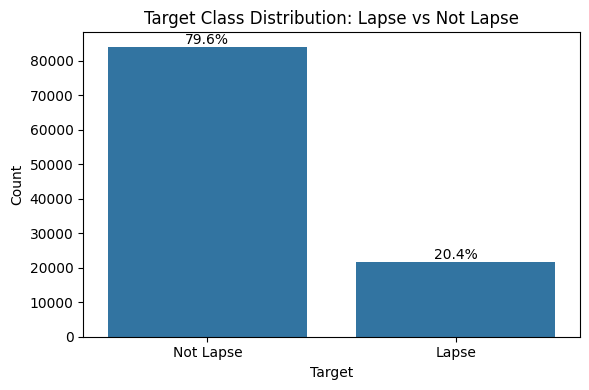

Imbalance Info: {0: 79.58599782104116, 1: 20.41400217895884}



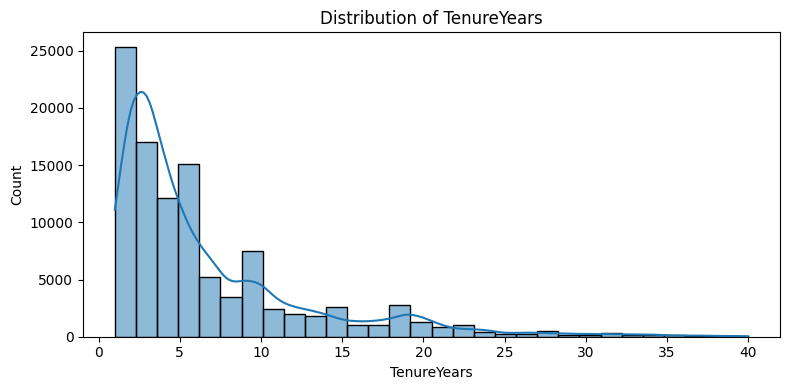

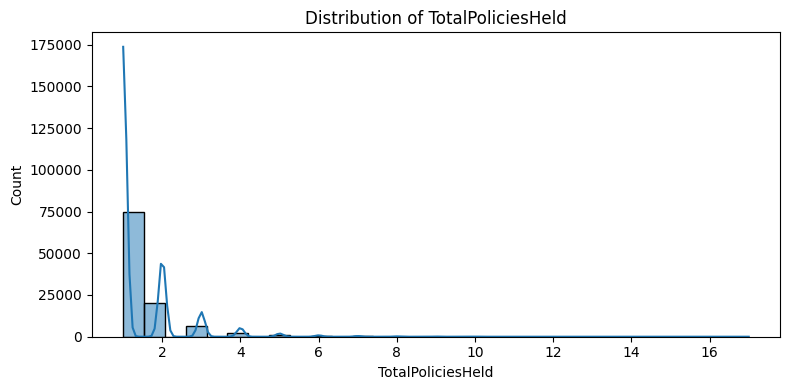

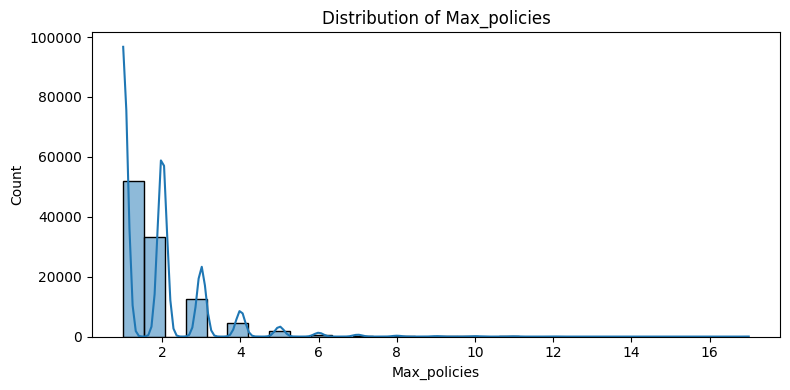

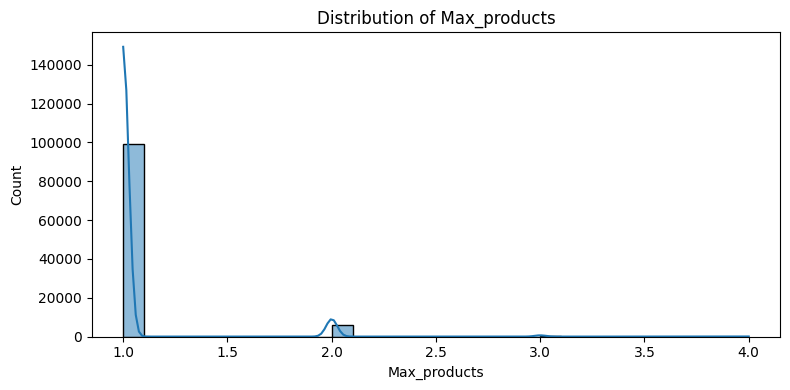

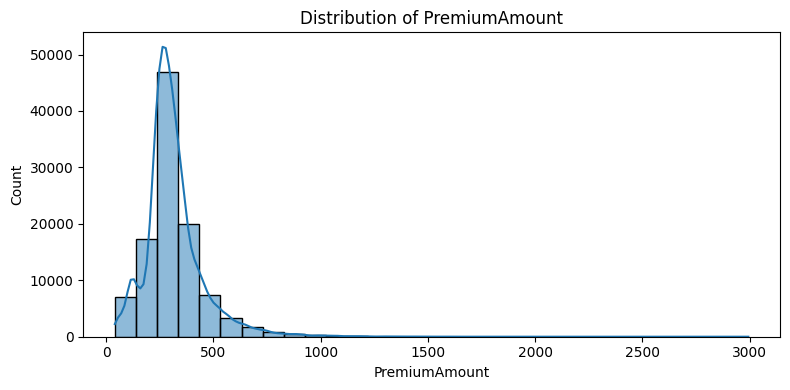

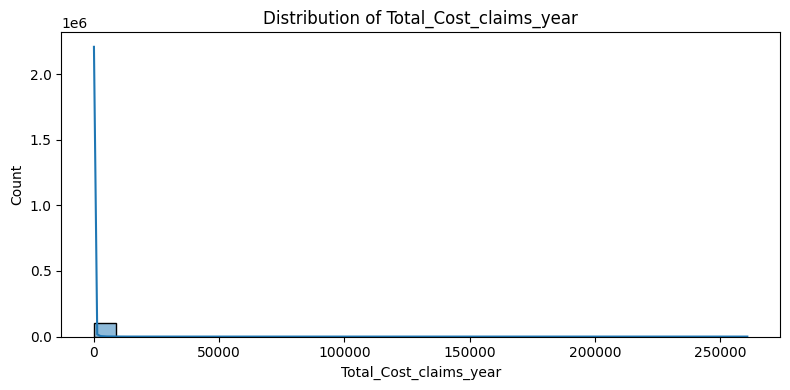

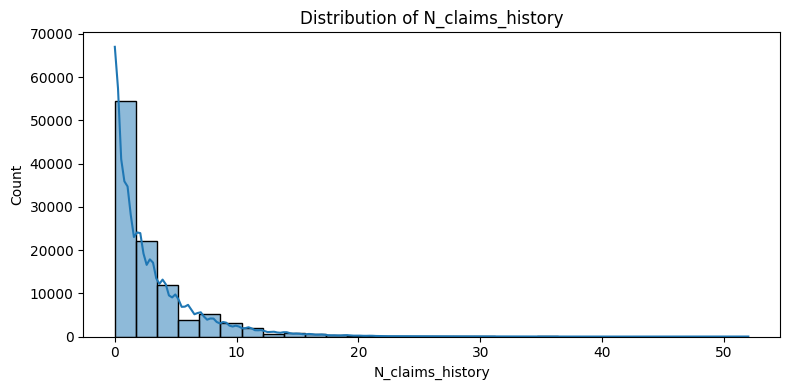

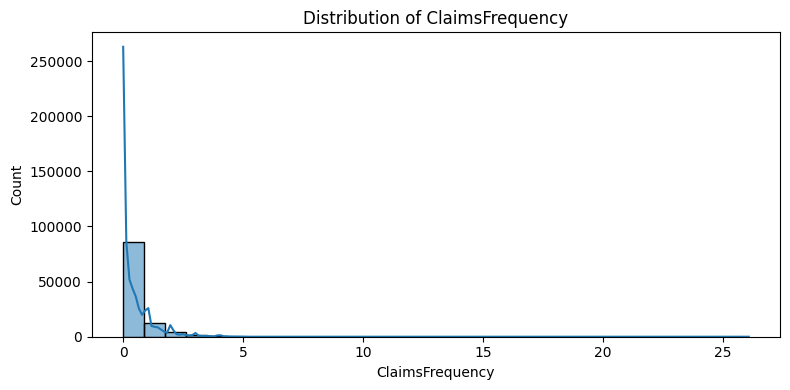

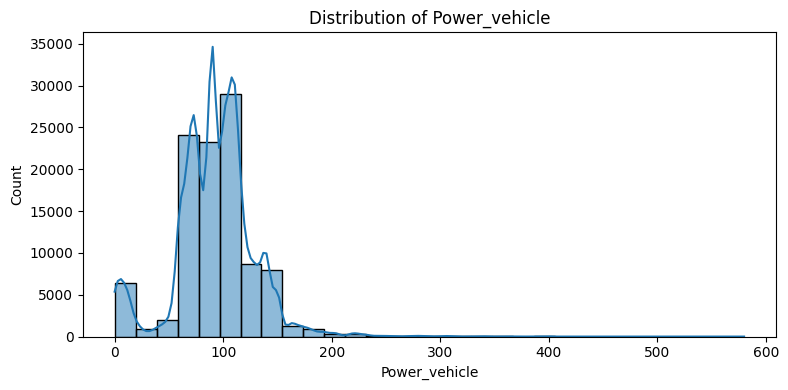

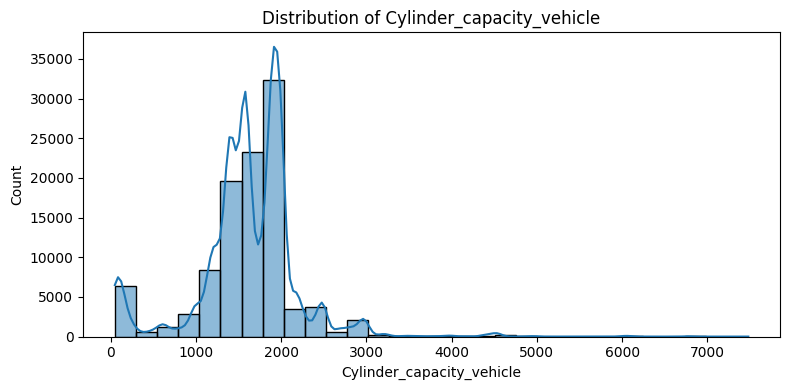

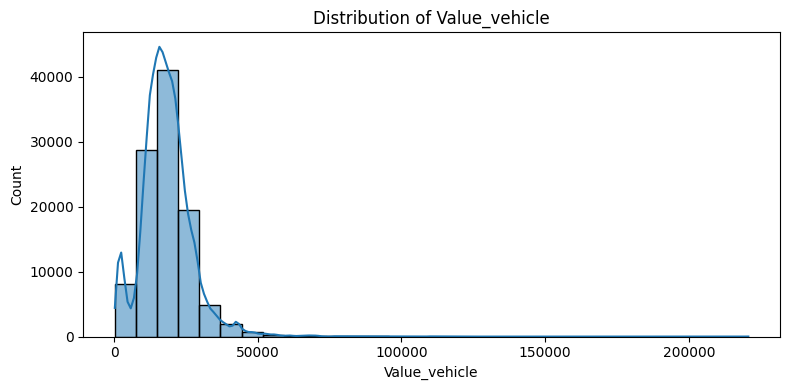

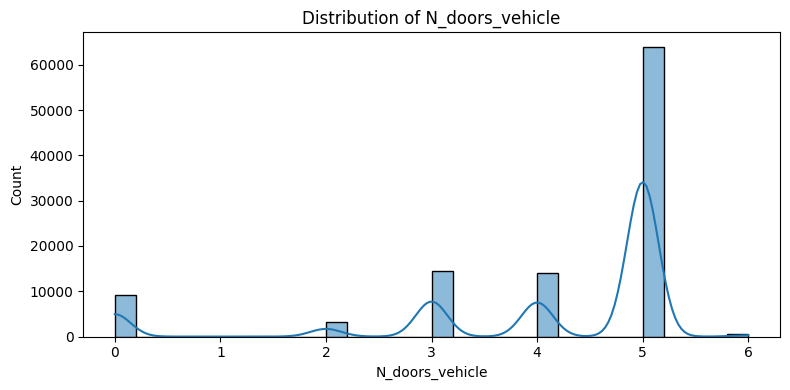

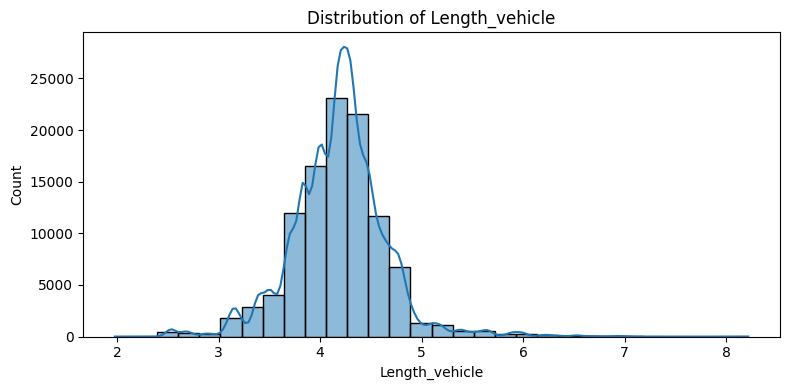

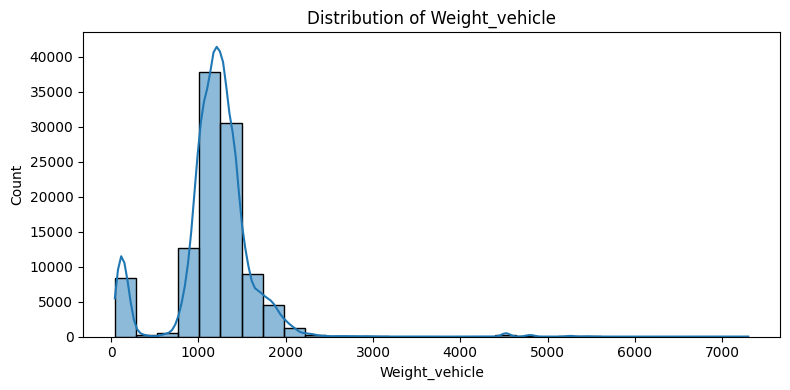

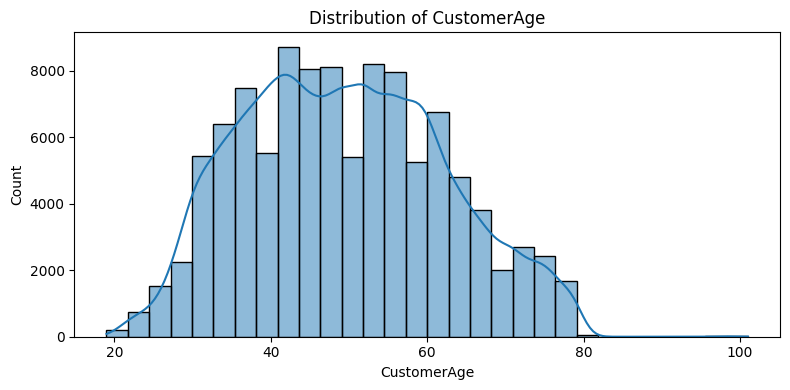

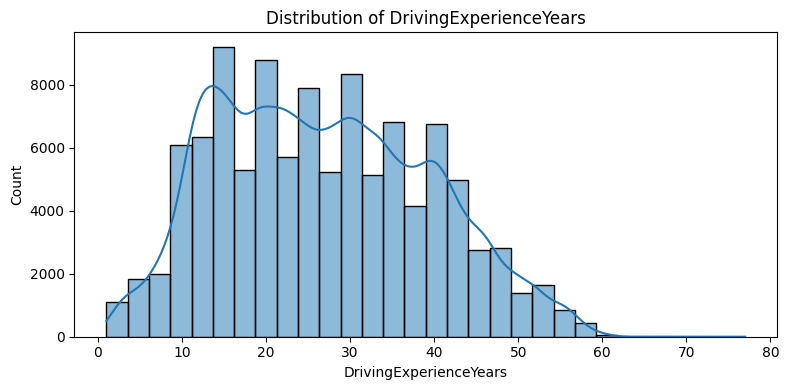

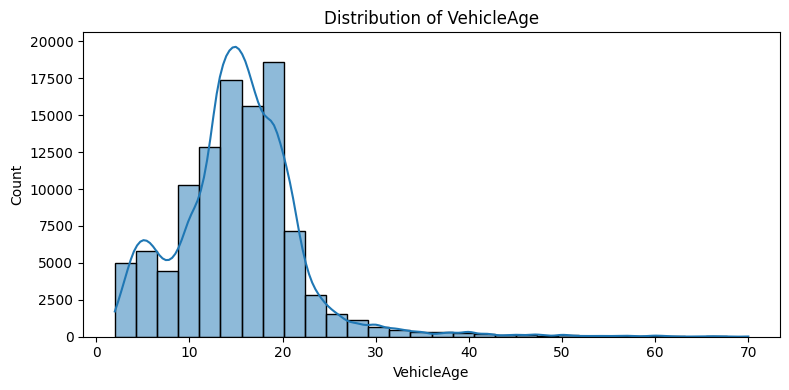

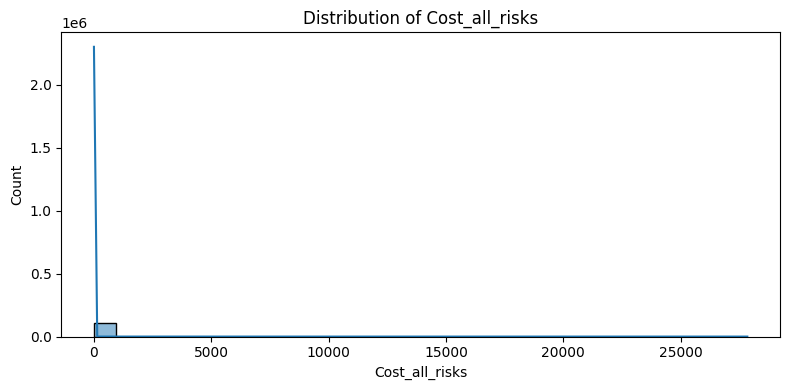

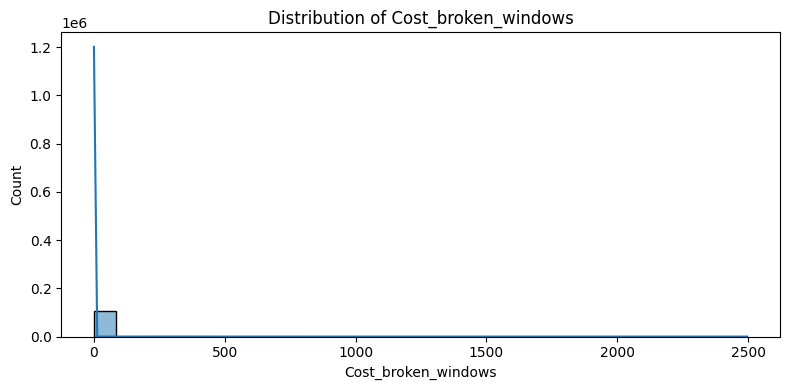

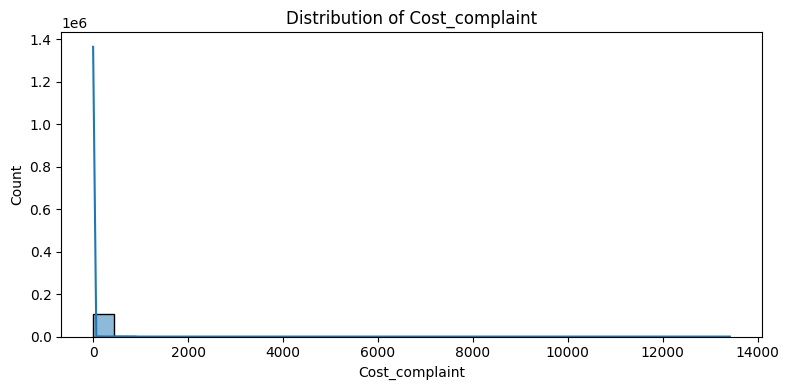

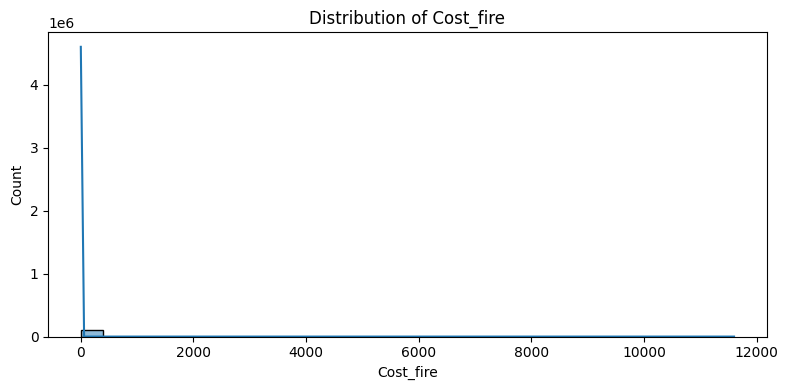

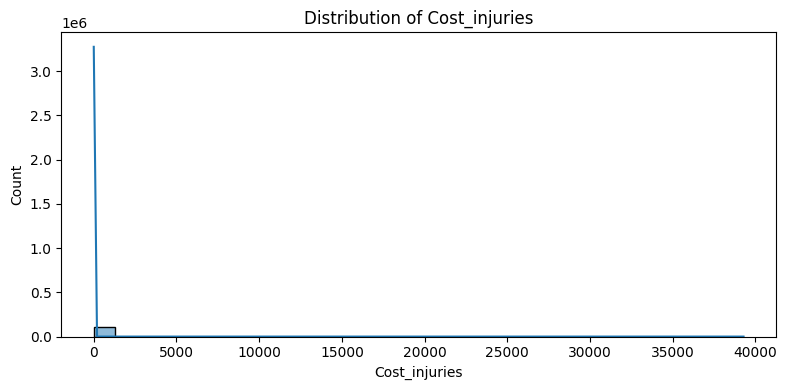

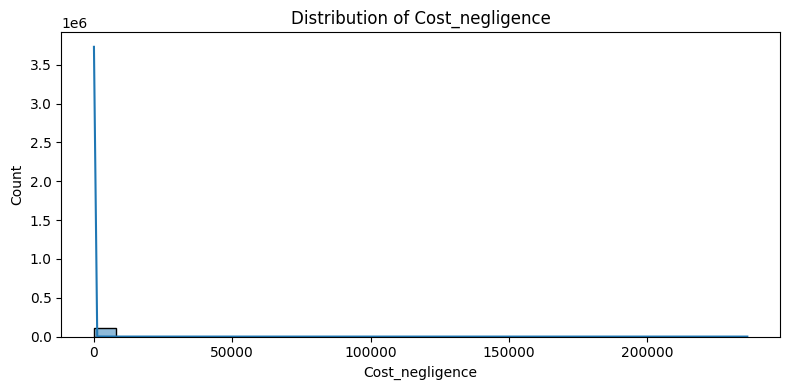

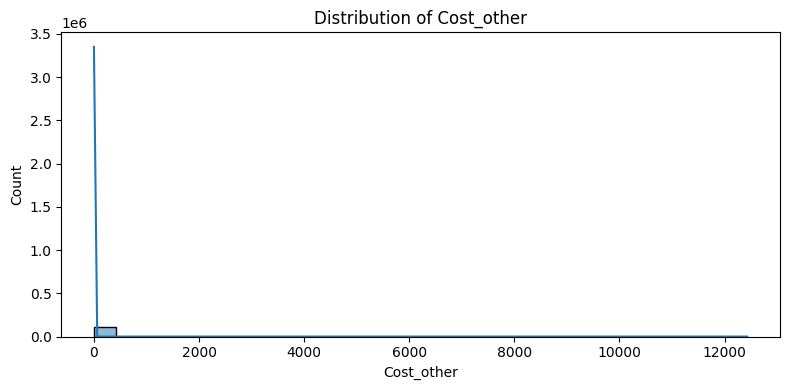

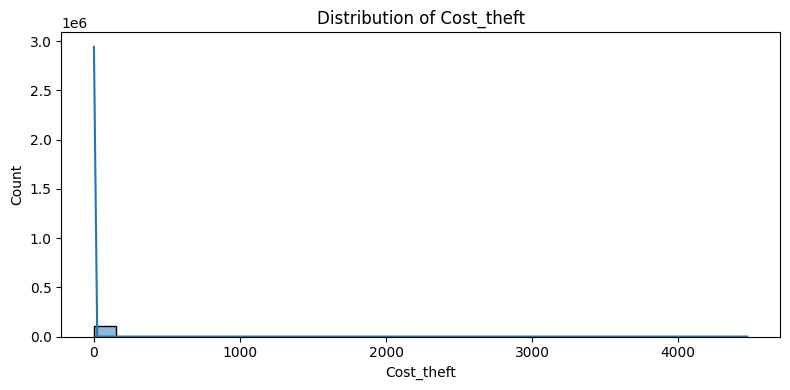

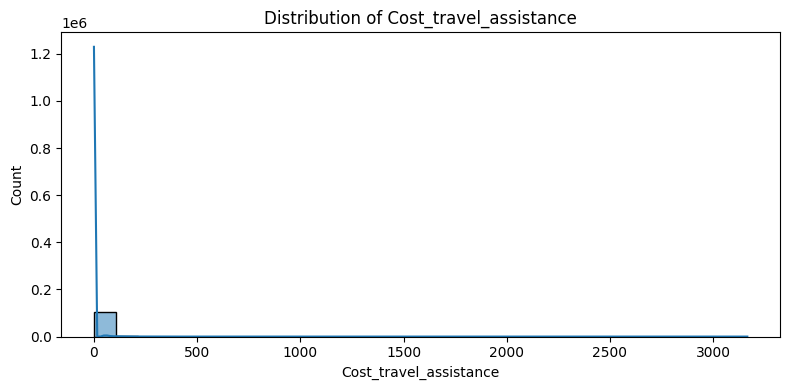

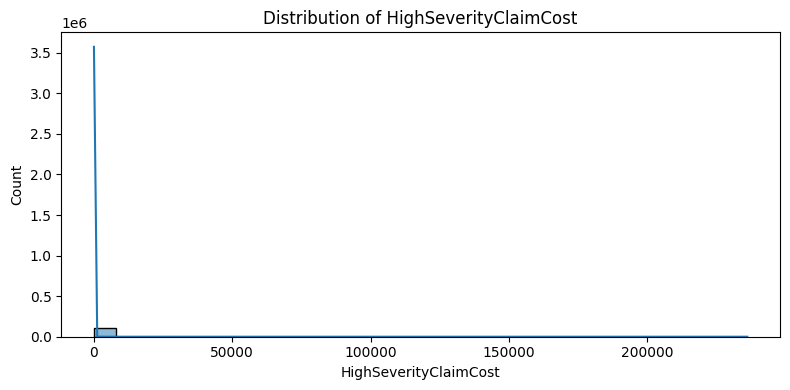

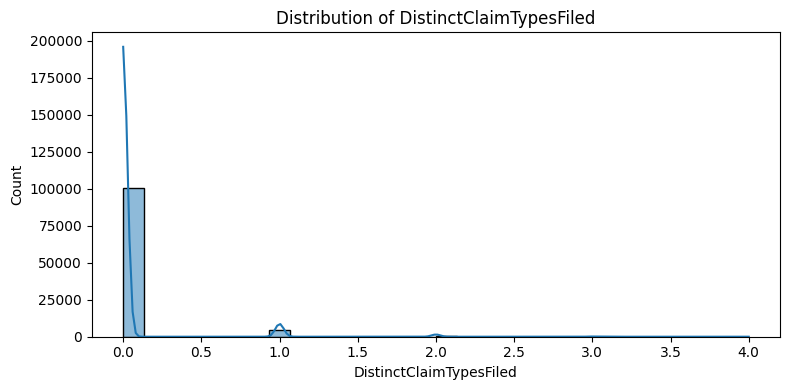

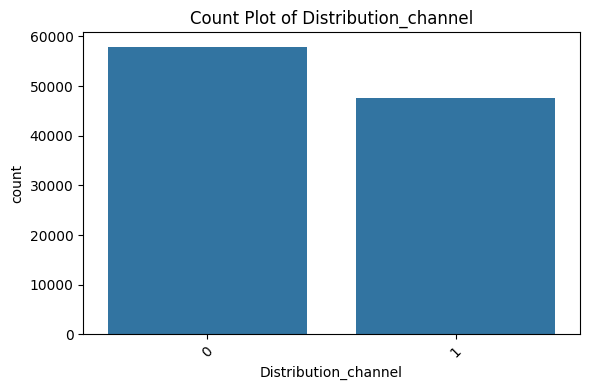

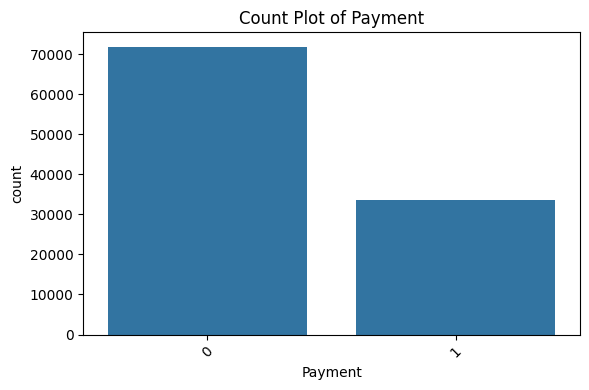

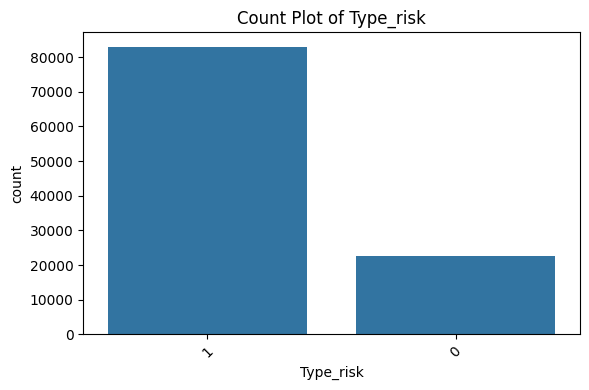

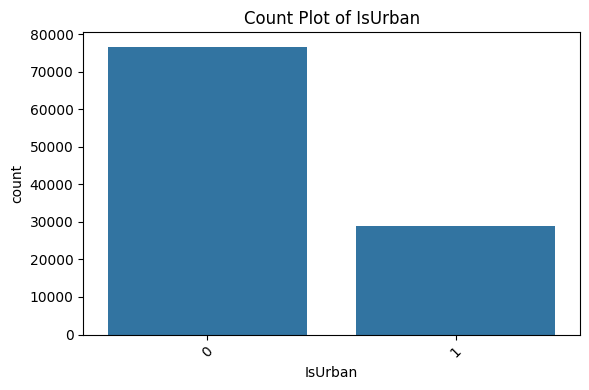

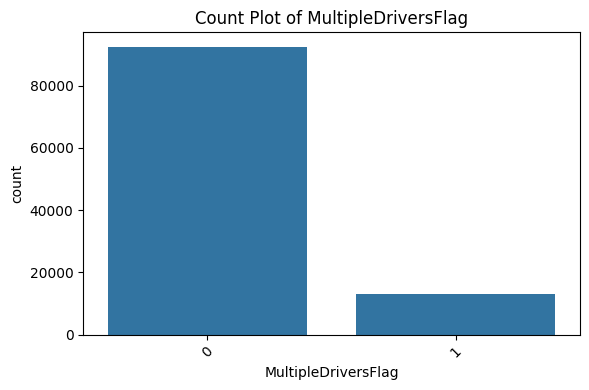

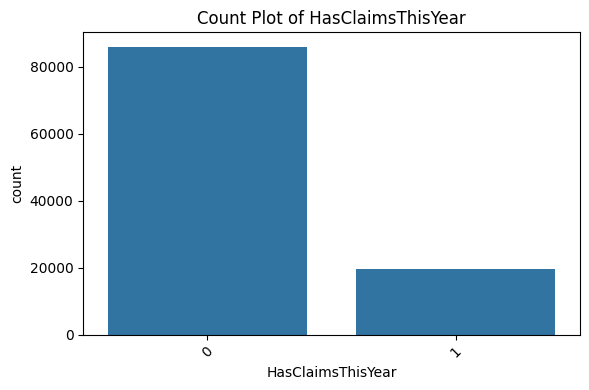

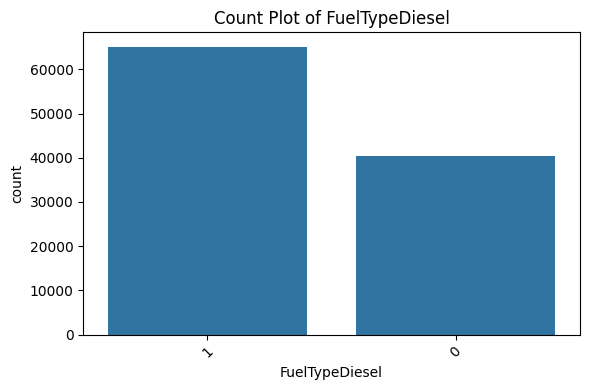

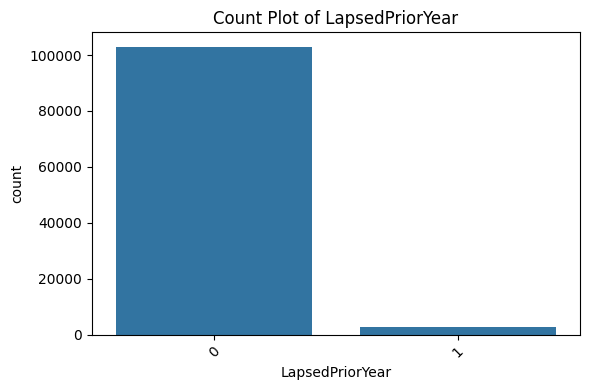

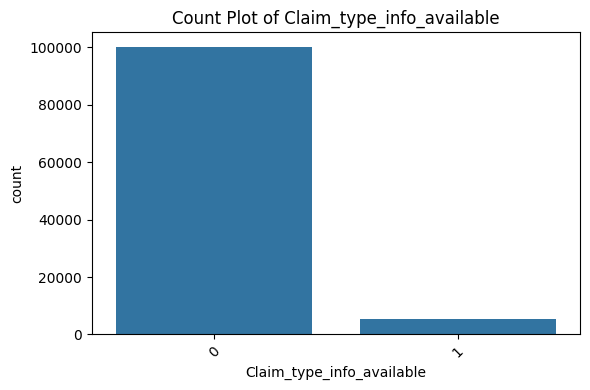

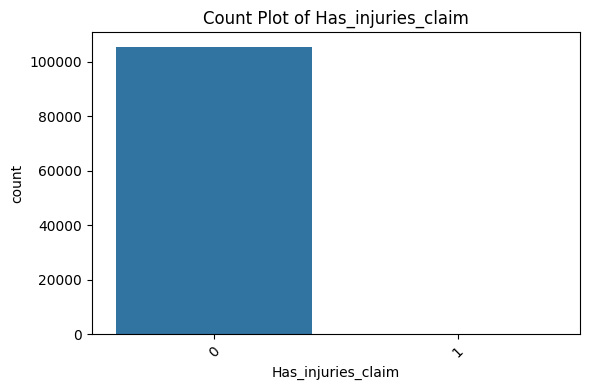

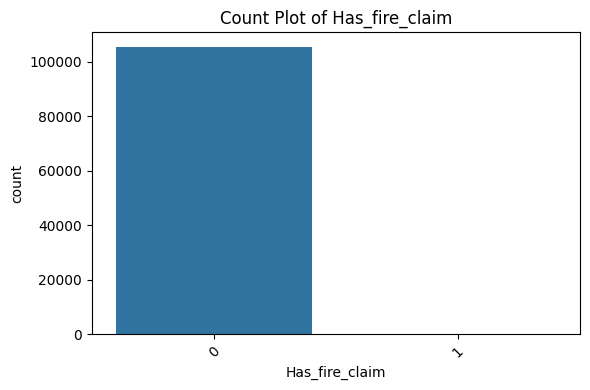

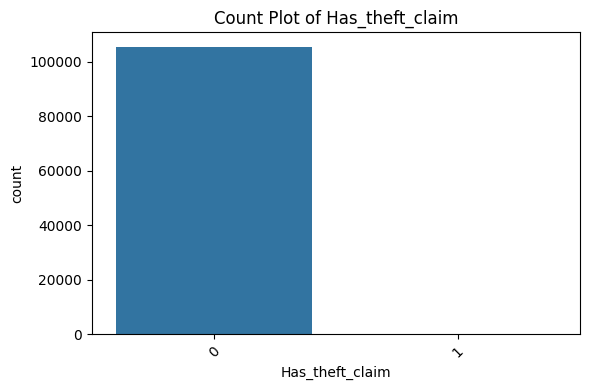

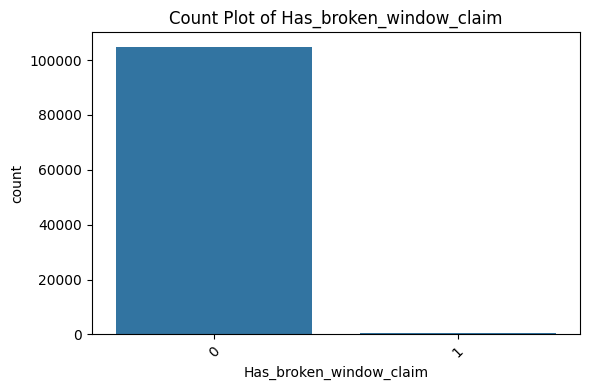

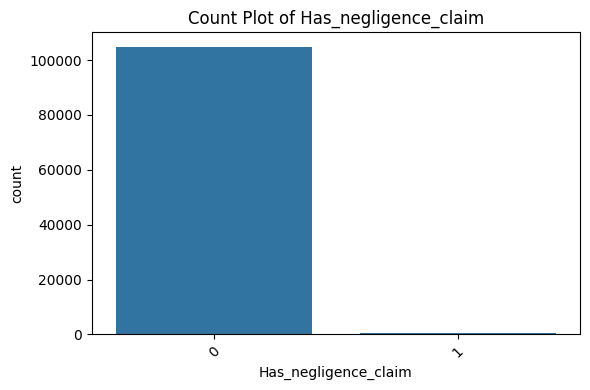

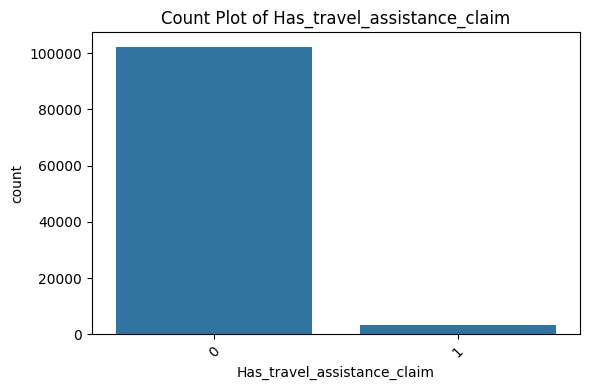

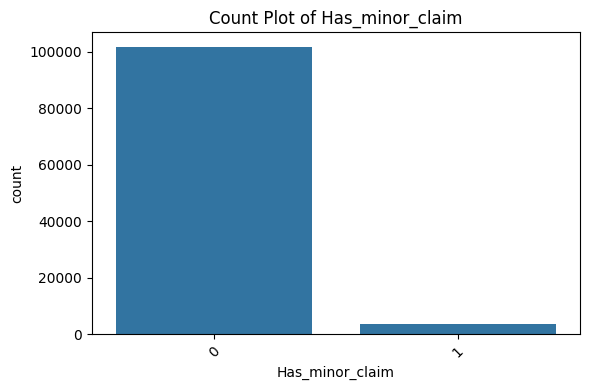

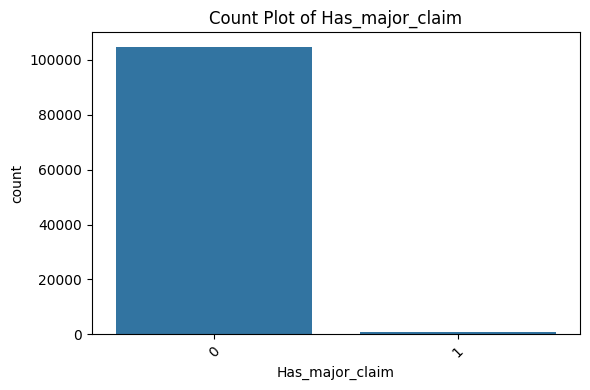

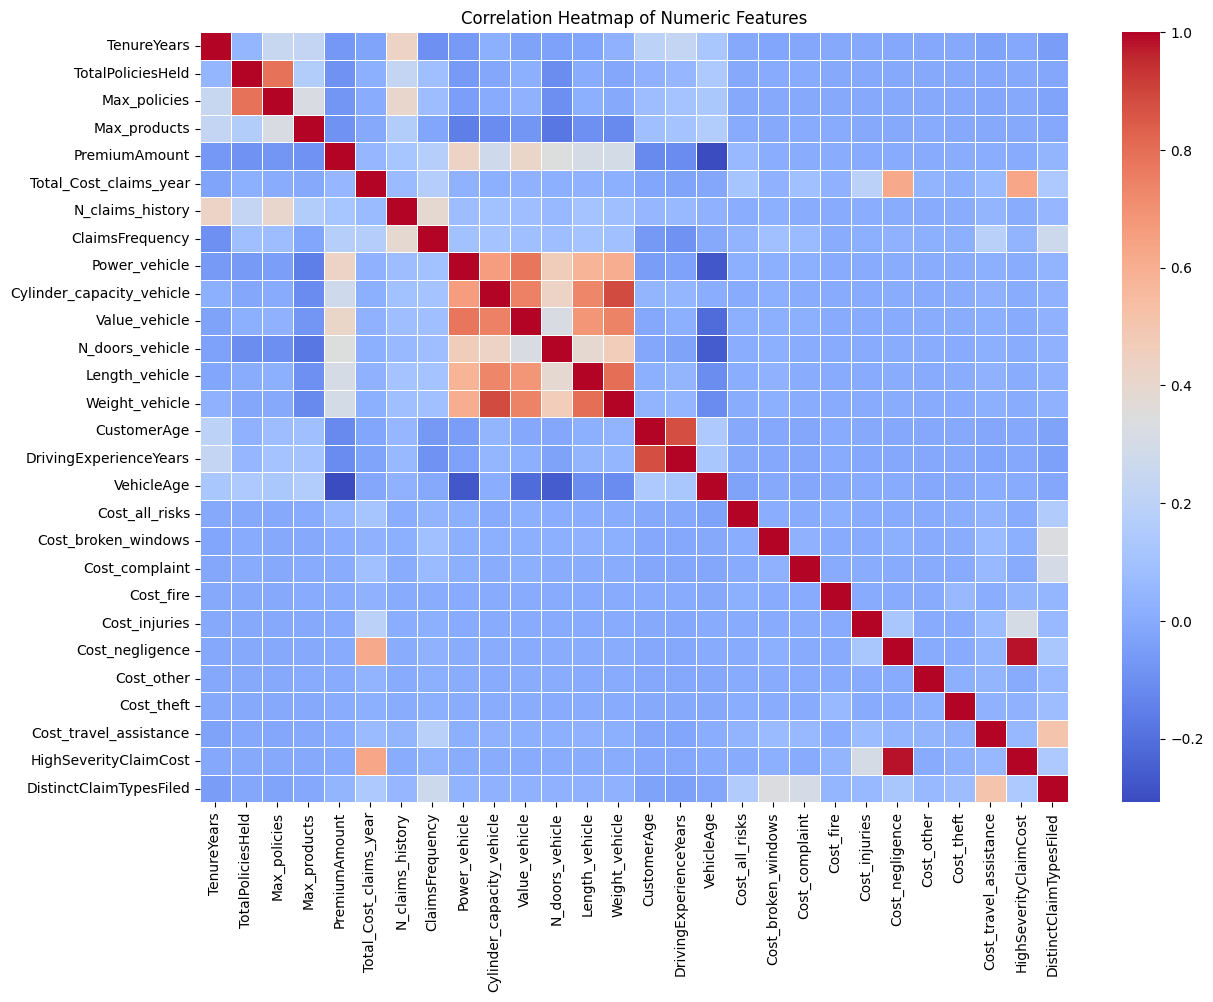

In [23]:
EDA_viz(df_enriched_knn, target, numeric_features, categorical_features)

## Skewness Check & Log Transformations

### What is Skewness?

Skewness is a measure of the asymmetry in the distribution of data points around the mean. In an ideal symmetrical distribution, the data is evenly distributed around the mean, forming a bell-shaped curve. However, in a skewed distribution, one tail of the distribution is longer or fatter than the other, indicating an imbalance.

- **Positive Skewness (Right Skew)**: Right tail of the distribution is longer or fatter than the left. Majority of data points are concentrated on the left side, with a few extreme values on the right. (i.e. Mean > Median & Mode < Median).

- **Negative Skewness (Left Skew)**: Left tail of the distribution is longer or fatter than the right. Majority of data points are concentrated on the right side, with a few extreme values on the left. (i.e. Mean < Median & Mode > Median).

- **Zero Skewness**: Symmetrical distribution, where the data is evenly distributed around the mean.

### Why I care about Skewness?

Skewness can adversely affect the performance of machine learning models. When the data is skewed, models may become biased towards the majority class, impacting the accuracy, precision, recall, and F1-score (i.e. Overfit to Majority Class & Underfit to Minority Class).

### Handling Skewness

Will be using Log Transformation to handle Skewness for this Project. By applying "log1p", the data's skewness can be reduced, and the variance can be stabilized, which can improve the performance of machine learning models.

In [24]:
# Skewness inspection
def skewness_check(df_enriched_knn, target, numeric_features, categorical_features):
    print("Skewness of numeric features:")
    
    df_enriched_logp = df_enriched_knn.copy()
    target = [target]
    
    skewed_features = df_enriched_logp[numeric_features].skew().sort_values(ascending=False)
    #print(skewed_features)

    # Top skewed features
    top_skewed = skewed_features[abs(skewed_features) > 1].index.tolist()
    print(f"Features with high skewness: {top_skewed}")

    print("\nGenerating EDA visualizations...")
    # Visualize top skewed features
    columns_to_replace = []
    for col in top_skewed:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_enriched_logp[col], kde=True, bins=30)
        mean_val = df_enriched_logp[col].mean()
        median_val = df_enriched_logp[col].median()
        std_val = df_enriched_logp[col].std()
        plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
        plt.axvline(mean_val + std_val, color='blue', linestyle=':', label=f'+1 STD')
        plt.axvline(mean_val - std_val, color='blue', linestyle=':', label=f'-1 STD')
        plt.legend()
        plt.title(f"Skewed Distribution: {col}")
        plt.tight_layout()
        plt.show()

        # Log transform (only if all values > 0)
        if (df_enriched_logp[col] > 0).all():
            df_enriched_logp[f'{col}_log'] = np.log1p(df_enriched_logp[col])
            plt.figure(figsize=(8, 4))
            sns.histplot(df_enriched_logp[f'{col}_log'], kde=True, bins=30)
            plt.title(f"Log-Transformed: {col}")
            plt.tight_layout()
            plt.show()
            
            # Ensure transformed features are used for modeling (Replace skewed features with their logp transformed equivalent)
            if col in numeric_features:
                columns_to_replace.append(col)
                numeric_features.remove(col)
                numeric_features.append(f'{col}_log')
    
    print(f"\n Skewed features {columns_to_replace} removed and replace with their logp transformed equivalent")
    
    df_enriched_logp = df_enriched_logp[numeric_features + categorical_features + target]
    
    return df_enriched_logp

Skewness of numeric features:
Features with high skewness: ['Cost_fire', 'Cost_negligence', 'HighSeverityClaimCost', 'Cost_other', 'Cost_injuries', 'Cost_theft', 'Total_Cost_claims_year', 'Cost_all_risks', 'Cost_complaint', 'Cost_travel_assistance', 'Cost_broken_windows', 'DistinctClaimTypesFiled', 'Max_products', 'ClaimsFrequency', 'TotalPoliciesHeld', 'N_claims_history', 'Max_policies', 'PremiumAmount', 'Value_vehicle', 'TenureYears', 'VehicleAge', 'Weight_vehicle', 'N_doors_vehicle']

Generating EDA visualizations...


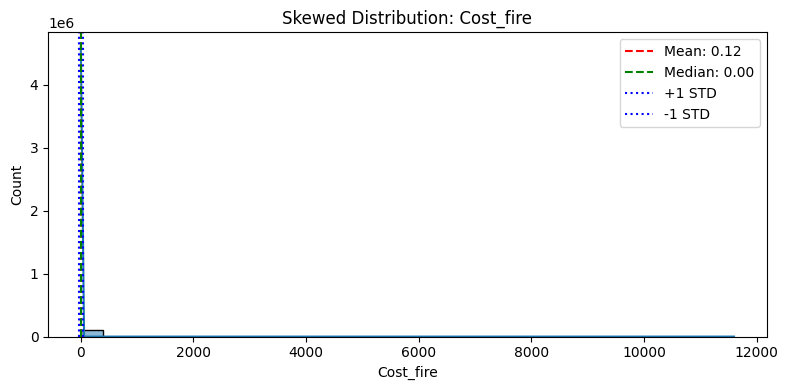

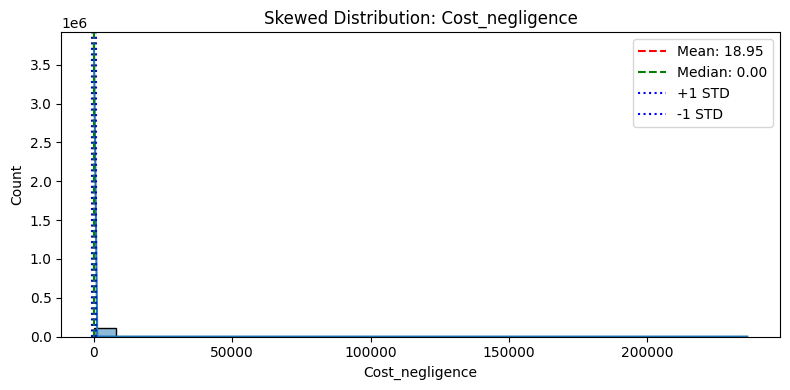

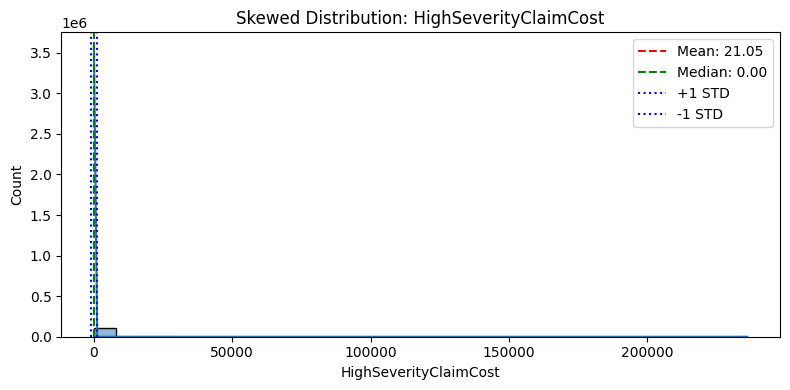

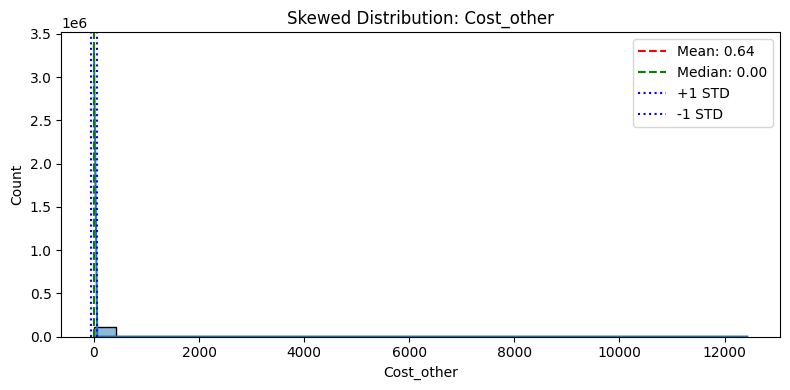

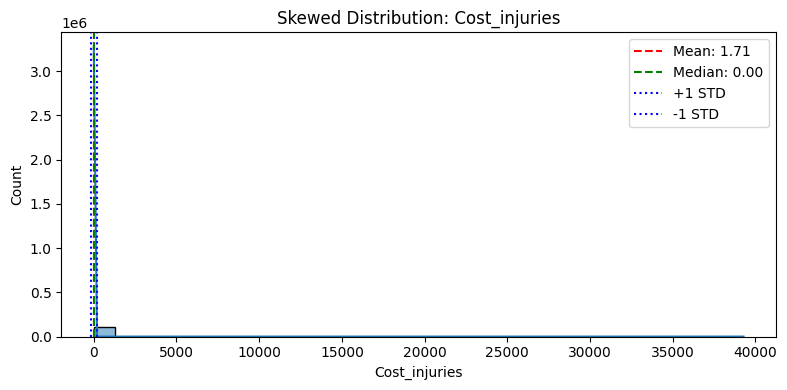

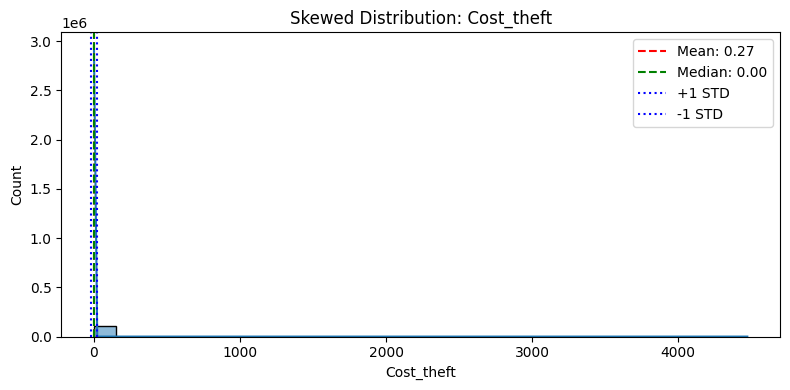

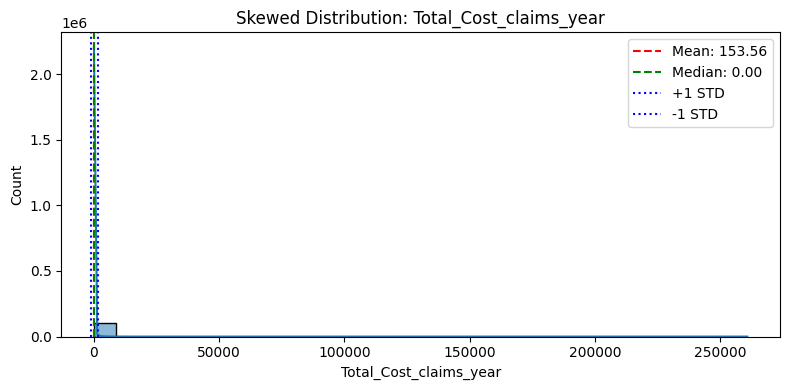

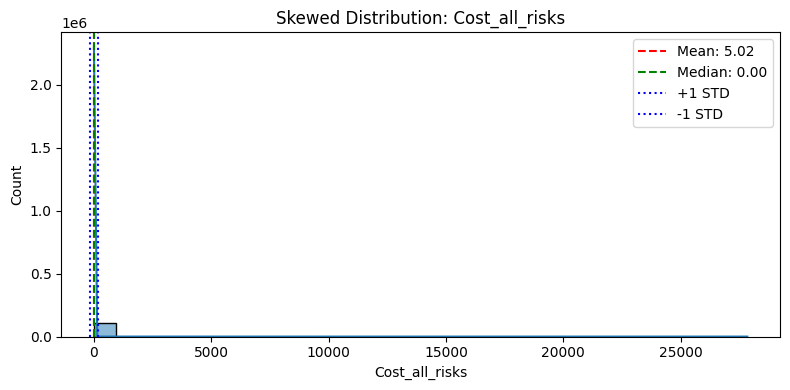

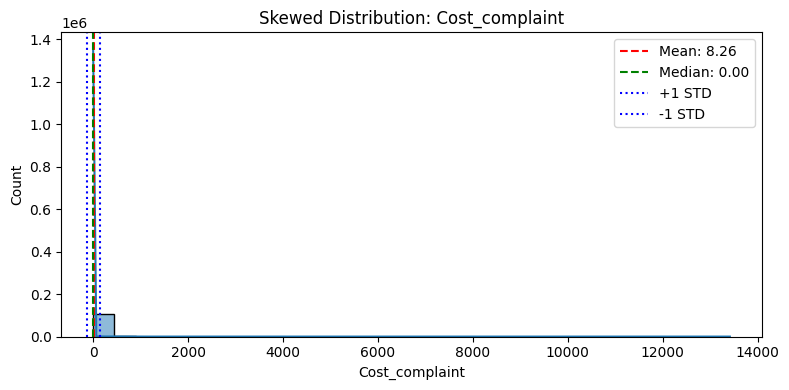

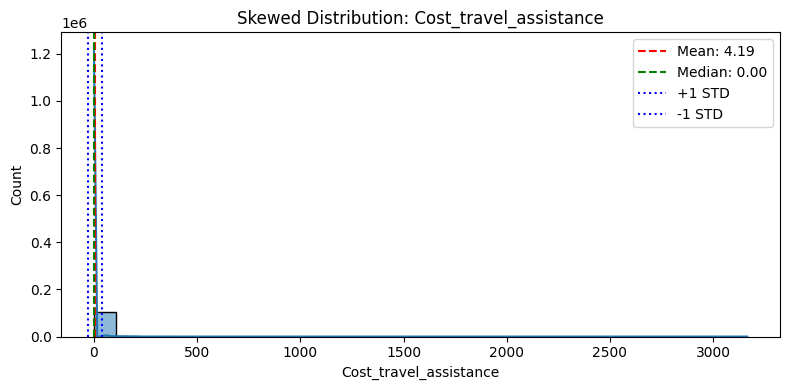

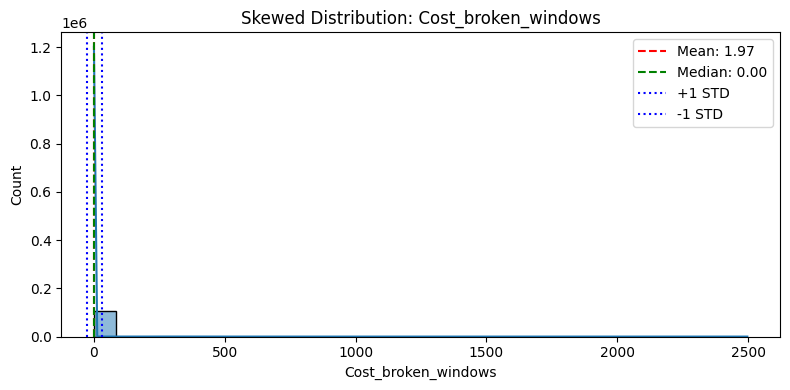

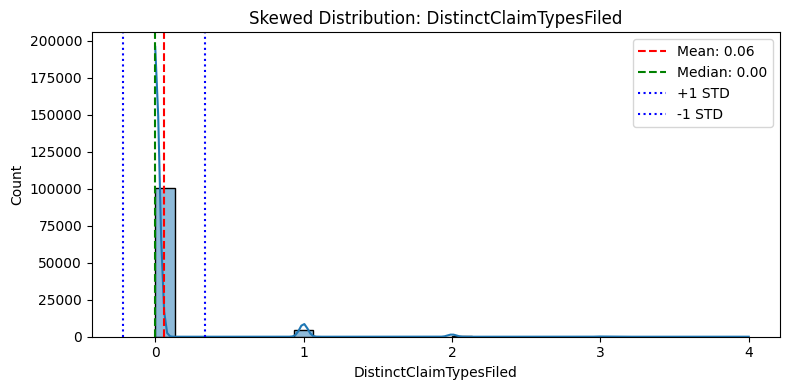

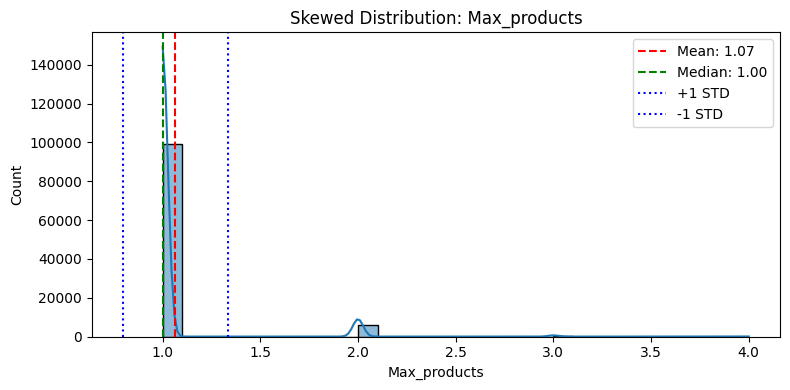

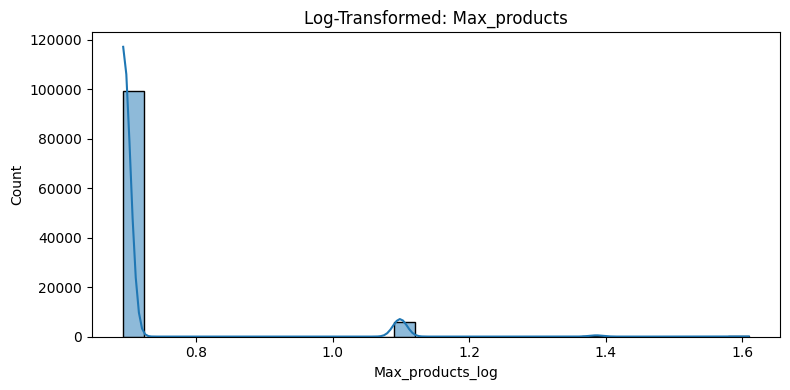

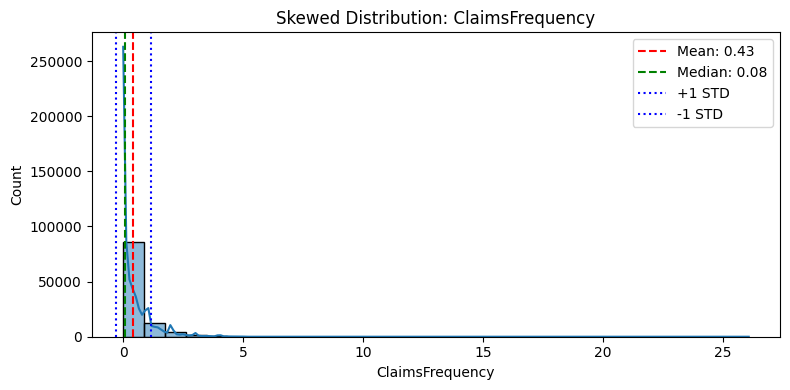

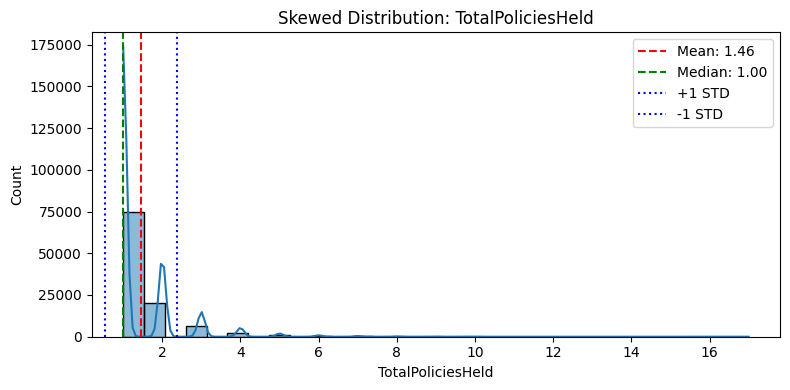

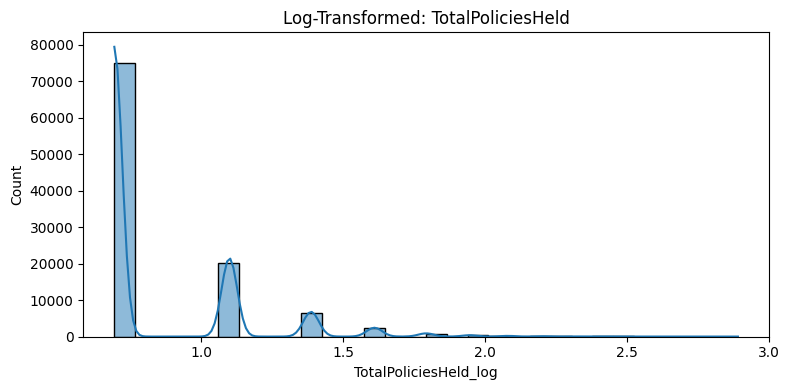

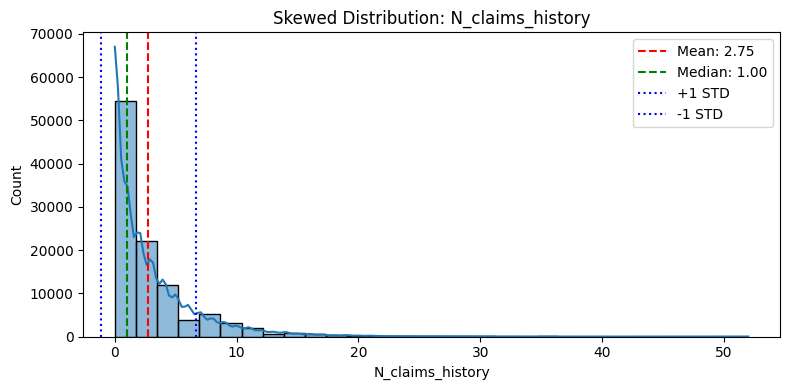

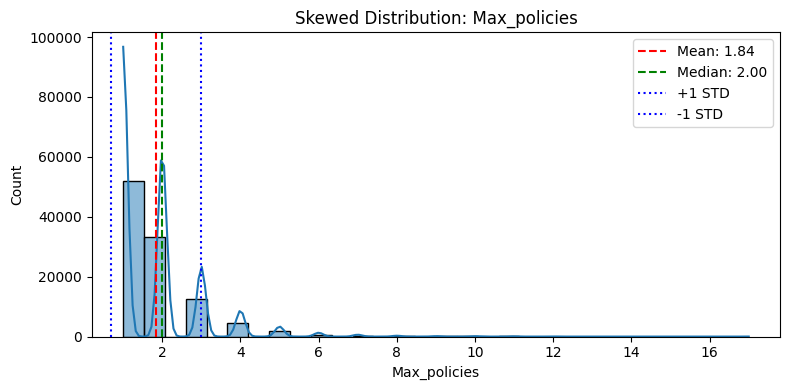

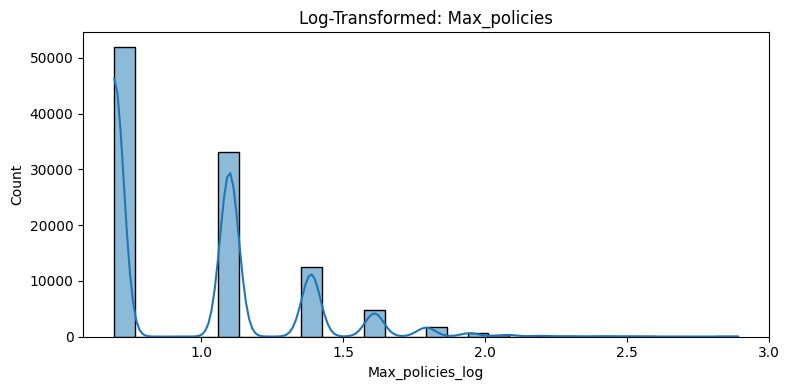

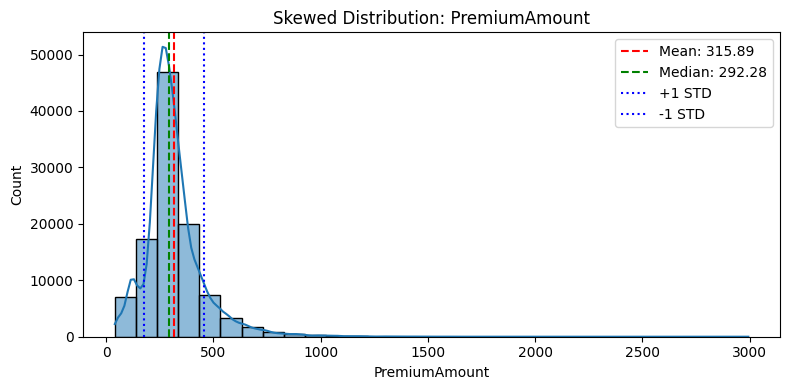

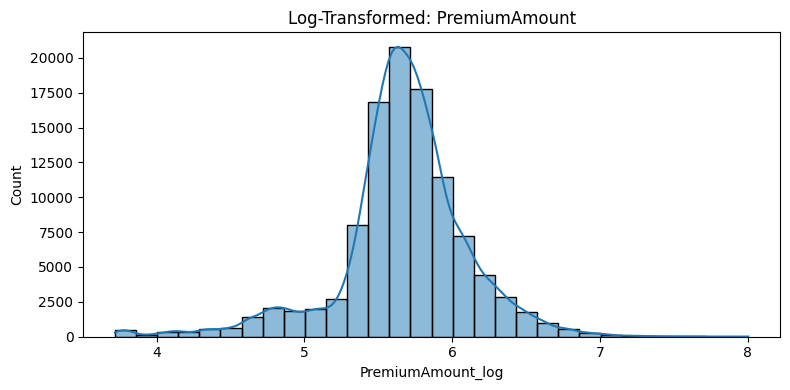

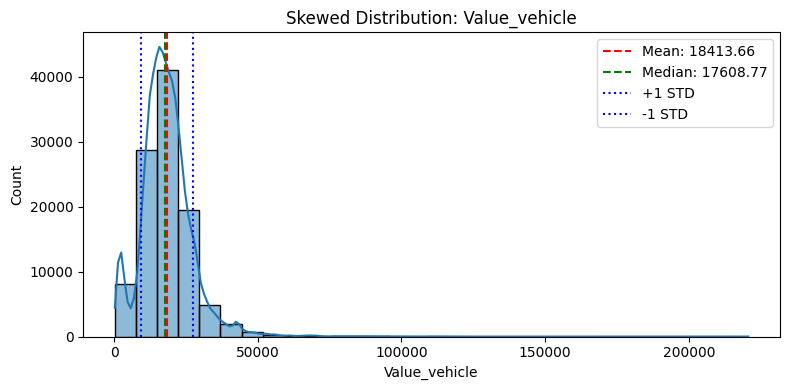

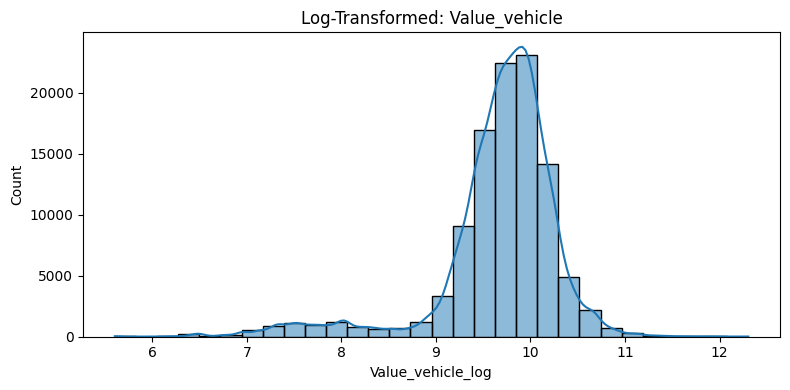

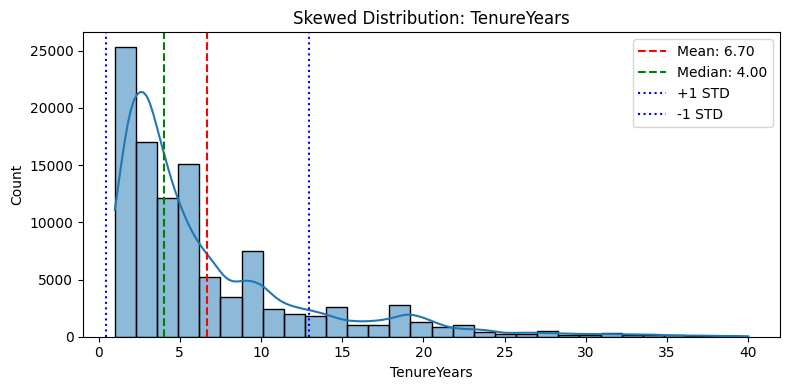

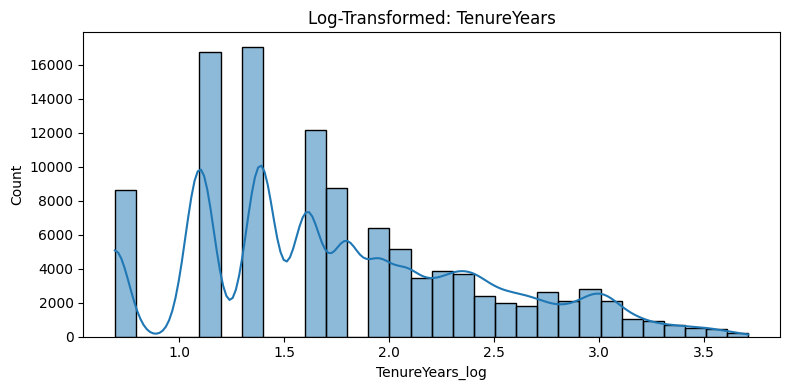

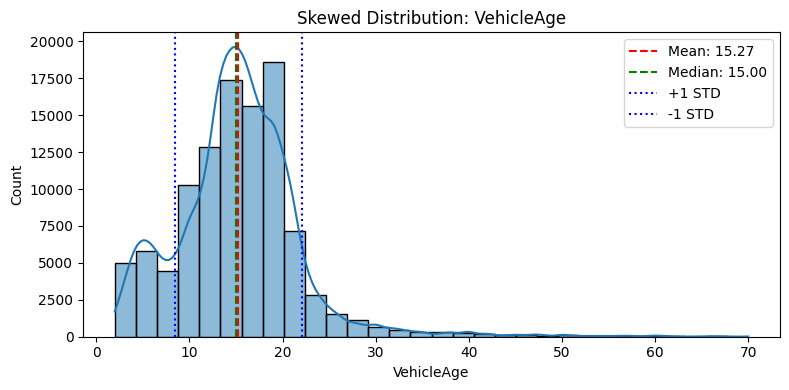

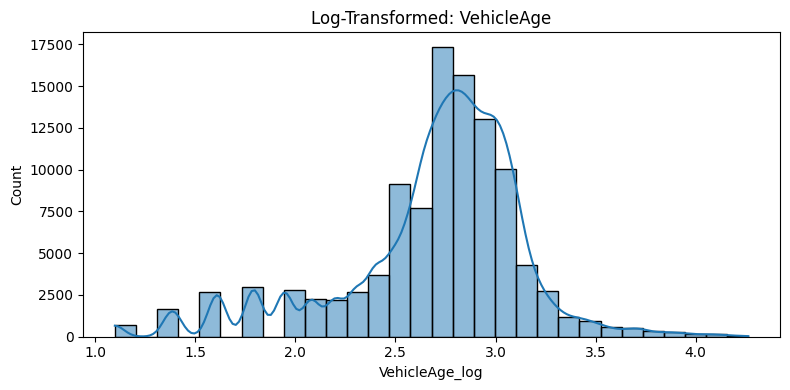

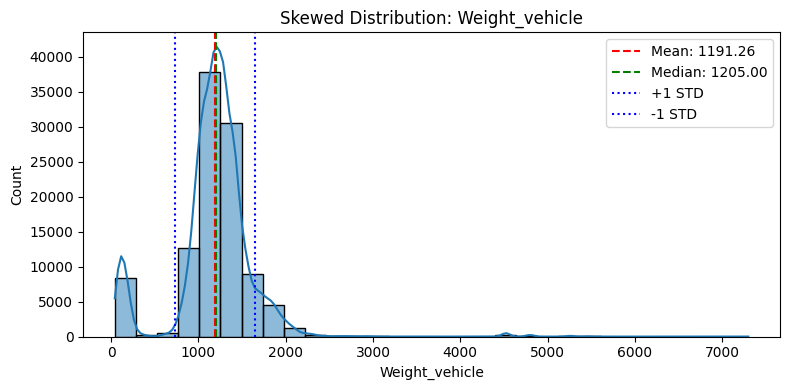

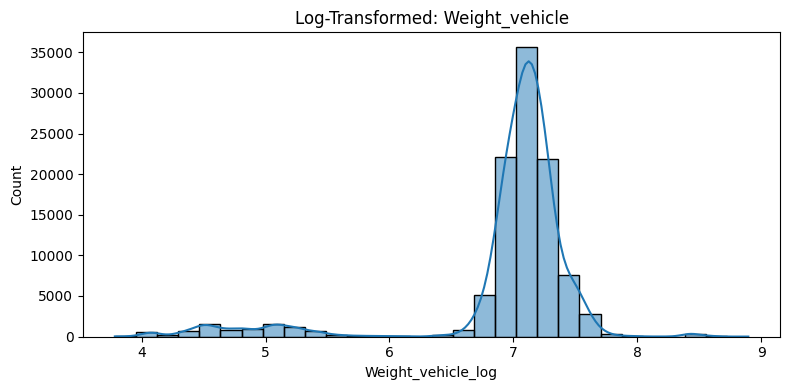

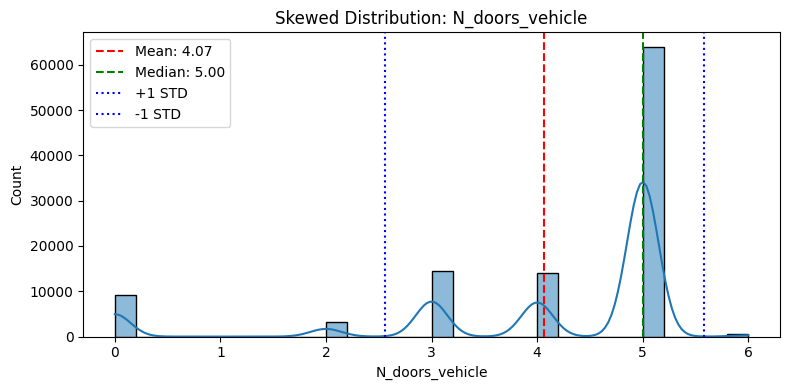


 Skewed features ['Max_products', 'TotalPoliciesHeld', 'Max_policies', 'PremiumAmount', 'Value_vehicle', 'TenureYears', 'VehicleAge', 'Weight_vehicle'] removed and replace with their logp transformed equivalent


In [25]:
df_enriched_logp = skewness_check(df_enriched_knn, target, numeric_features, categorical_features)

In [26]:
df_enriched_logp.head()

Total_Cost_claims_year  N_claims_history  ClaimsFrequency  Power_vehicle  \
0                     0.0                 0              0.0             80   
1                     0.0                 0              0.0             80   
2                     0.0                 0              0.0             80   
3                     0.0                 0              0.0             80   
4                     0.0                 0              0.0             80   

   Cylinder_capacity_vehicle  N_doors_vehicle  Length_vehicle  CustomerAge  \
0                        599                0           3.495           63   
1                        599                0           3.495           63   
2                        599                0           3.495           63   
3                        599                0           3.495           63   
4                        599                0           3.495           63   

   DrivingExperienceYears  Cost_all_risks  Cost_broken_windows  \
0                      43             0.0                  0.0   
1                      43             0.0                  0.0   
2                      43             0.0                  0.0   
3                      43             0.0                  0.0   
4                      43             0.0                  0.0   

   Cost_complaint  Cost_fire  Cost_injuries  Cost_negligence  Cost_other  \
0             0.0        0.0            0.0              0.0         0.0   
1             0.0        0.0            0.0              0.0         0.0   
2             0.0        0.0            0.0              0.0         0.0   
3             0.0        0.0            0.0              0.0         0.0   
4             0.0        0.0            0.0              0.0         0.0   

   Cost_theft  Cost_travel_assistance  HighSeverityClaimCost  \
0         0.0                     0.0                    0.0   
1         0.0                     0.0                    0.0   
2         0.0                     0.0                    0.0   
3         0.0                     0.0                    0.0   
4         0.0                     0.0                    0.0   

   DistinctClaimTypesFiled  Max_products_log  TotalPoliciesHeld_log  \
0                        0          0.693147               0.693147   
1                        0          0.693147               0.693147   
2                        0          0.693147               1.098612   
3                        0          0.693147               1.098612   
4                        0          0.693147               1.098612   

   Max_policies_log  PremiumAmount_log  Value_vehicle_log  TenureYears_log  \
0          1.098612           5.409501           8.863474         1.609438   
1          1.098612           5.369614           8.863474         1.609438   
2          1.098612           5.374537           8.863474         1.609438   
3          1.098612           5.384449           8.863474         1.609438   
4          1.098612           5.369242           8.863474         1.609438   

   VehicleAge_log  Weight_vehicle_log  Distribution_channel  Payment  \
0        2.833213            5.252273                     0        0   
1        2.833213            5.252273                     0        0   
2        2.833213            5.252273                     0        0   
3        2.833213            5.252273                     0        0   
4        2.833213            5.252273                     0        1   

   Type_risk  IsUrban  MultipleDriversFlag  HasClaimsThisYear  FuelTypeDiesel  \
0          0        0                    0                  0               0   
1          0        0                    0                  0               0   
2          0        0                    0                  0               0   
3          0        0                    0                  0               0   
4          0        0                    0                  0               0   

   L

## Feature Selection

In [27]:
X = df_enriched_logp.drop([target], axis=1)
y = df_enriched_logp[target]

### Multicollinearity Check - VIF

In [28]:
#VIF
def VIF_calc(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Print and filter high VIF features
    print("Variance Inflation Factors:\n")
    print(vif_data.sort_values("VIF", ascending=False))

    # Drop features with VIF > 11 (optional)
    high_vif_features = vif_data[vif_data["VIF"] > 10]['feature'].tolist()
    if high_vif_features:
        print(f"\nDropping high VIF features: {high_vif_features}")
        X.drop(columns=high_vif_features, inplace=True)
        
    return X

In [29]:
%%time
#X = VIF_calc(X)

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


In [30]:
print("\n Final feature list after feature selection using VIF : \n")
feature_list = pd.DataFrame(X.columns, columns=['final_features'])
feature_list


 Final feature list after feature selection using VIF : 



final_features
0        Total_Cost_claims_year
1              N_claims_history
2               ClaimsFrequency
3                 Power_vehicle
4     Cylinder_capacity_vehicle
5               N_doors_vehicle
6                Length_vehicle
7                   CustomerAge
8        DrivingExperienceYears
9                Cost_all_risks
10          Cost_broken_windows
11               Cost_complaint
12                    Cost_fire
13                Cost_injuries
14              Cost_negligence
15                   Cost_other
16                   Cost_theft
17       Cost_travel_assistance
18        HighSeverityClaimCost
19      DistinctClaimTypesFiled
20             Max_products_log
21        TotalPoliciesHeld_log
22             Max_policies_log
23            PremiumAmount_log
24            Value_vehicle_log
25              TenureYears_log
26               VehicleAge_log
27           Weight_vehicle_log
28         Distribution_channel
29                      Payment
30                    Type_risk
31                      IsUrban
32          MultipleDriversFlag
33            HasClaimsThisYear
34               FuelTypeDiesel
35              LapsedPriorYear
36    Claim_type_info_available
37           Has_injuries_claim
38               Has_fire_claim
39              Has_theft_claim
40      Has_broken_window_claim
41         Has_negligence_claim
42  Has_travel_assistance_claim
43              Has_minor_claim
44              Has_major_claim

## Model Training & Selection

In [31]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [32]:
# === Scale ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [33]:
def plot_classDist(y_train, y_resampled=y_train, syn_data_method="Original"):
    if len(y_resampled) != len(y_train):
        # Plot class distribution before and after either oversampling or undersampling
        fig, axes = plt.subplots(1, 2, figsize=(11, 4))

        # Before oversampling or undersampling
        sns.countplot(x=y_train, ax=axes[0])
        y_train_counts = y_train.value_counts()
        y_train_pct = y_train_counts / y_train_counts.sum() * 100
        for i, count in enumerate(y_train_counts):
            pct = y_train_pct[i]
            axes[0].text(i, count, f"{count} ({pct:.1f}%)", ha='center', va='bottom', fontsize=8)
        axes[0].set_title(f"Class Distribution Before {syn_data_method}")
        axes[0].set_xlabel("Target")
        axes[0].set_ylabel("Count")
        axes[0].set_xticklabels(['Not Lapse', 'Lapse'])

        # After oversampling or undersampling
        sns.countplot(x=y_resampled, ax=axes[1])
        y_resampled_counts = y_resampled.value_counts()
        y_resampled_pct = y_resampled_counts / y_resampled_counts.sum() * 100
        for i, count in enumerate(y_resampled_counts):
            pct = y_resampled_pct[i]
            axes[1].text(i, count, f"{count} ({pct:.1f}%)", ha='center', va='bottom', fontsize=8)
        axes[1].set_title(f"Class Distribution After {syn_data_method}")
        axes[1].set_xlabel("Target")
        axes[1].set_ylabel("Count")
        axes[1].set_xticklabels(['Not Lapse', 'Lapse'])

        plt.tight_layout()
        plt.show()
        
    else:
        # Before oversampling or undersampling
        sns.countplot(x=y_train, ax=axes[0])
        y_train_counts = y_train.value_counts()
        y_train_pct = y_train_counts / y_train_counts.sum() * 100
        for i, count in enumerate(y_train_counts):
            pct = y_train_pct[i]
            axes[0].text(i, count, f"{count} ({pct:.1f}%)", ha='center', va='bottom', fontsize=8)
        axes[0].set_title(f"Class Distribution of {syn_data_method} data")
        axes[0].set_xlabel("Target")
        axes[0].set_ylabel("Count")
        axes[0].set_xticklabels(['Not Lapse', 'Lapse'])
        
        plt.tight_layout()
        plt.show()

In [34]:
## Oversampling using SMOTE

def smote_oversample(X_train_scaled, y_train):
    
    #SMOTE
    smote_os = SMOTE(random_state = 42)
    X_smote, y_smote = smote_os.fit_resample(X_train_scaled, y_train)
    
    #BorderlineSMOTE
    smote_border = BorderlineSMOTE(random_state = 42, kind = 'borderline-2')
    X_smoteborder, y_smoteborder = smote_border.fit_resample(X_train_scaled, y_train)
    
    #SVM SMOTE
    smote_svm = SVMSMOTE(random_state = 42)
    X_smotesvm, y_smotesvm = smote_svm.fit_resample(X_train_scaled, y_train)
    
    plot_classDist(y_train, y_smote, 'SMOTE')
    
    return X_smote, y_smote, X_smoteborder, y_smoteborder, X_smotesvm, y_smotesvm

In [35]:
def random_undersample(X_train_scaled, y_train):
    # Create a RandomUnderSampler object
    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
    
    # Balancing the data
    X_undersampled, y_undersampled = rus.fit_resample(X_train_scaled, y_train)
    
    plot_classDist(y_train, y_undersampled, 'Random Undersampling')
    
    return X_undersampled, y_undersampled

### Training data for model training

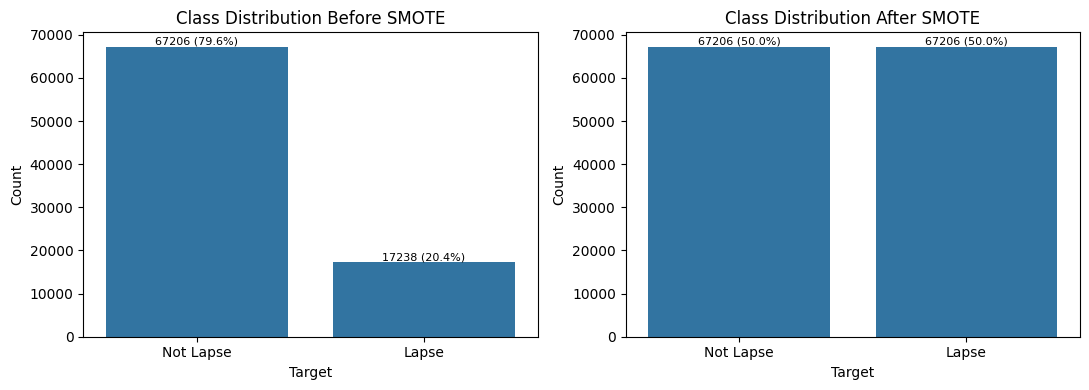

CPU times: user 4min 42s, sys: 6.05 s, total: 4min 48s
Wall time: 4min 25s


In [36]:
%%time
# Training data after applying various SMOTE techniques to oversample the minority class "1"
X_smote, y_smote, X_smoteborder, y_smoteborder, X_smotesvm, y_smotesvm = smote_oversample(X_train_scaled, y_train)

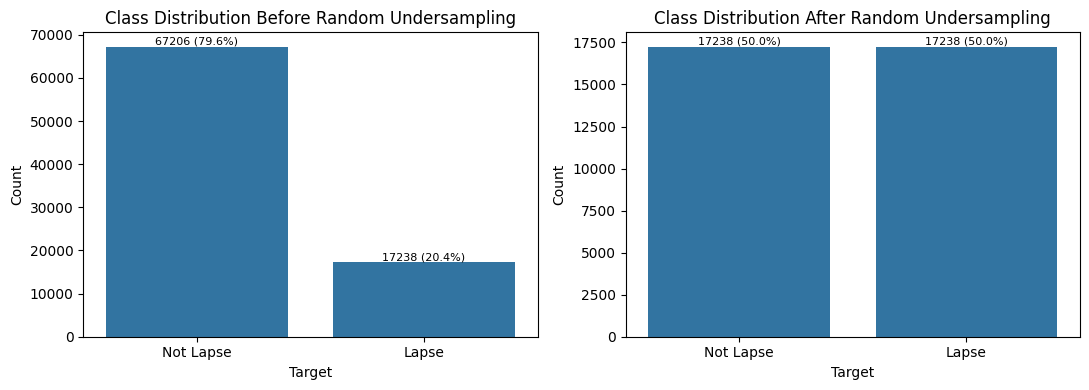

CPU times: user 668 ms, sys: 19 ms, total: 687 ms
Wall time: 230 ms


In [37]:
%%time
# Training data after applying Random Samping to reduce the majority class "0"
X_undersampled, y_undersampled = random_undersample(X_train_scaled, y_train)

### Logistic Regression Classifier (Baseline)

In [38]:
def logReg(X_train_scaled, y_train, X_test_scaled, y_test):
    logreg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    logreg_model.fit(X_train_scaled, y_train)
    
    # === Perform 5-fold cross validation on training data with  ===
    print("Training with 5-fold cross validation....")
    metric = 'f1'
    scores = cross_val_score(logreg_model, X_train_scaled, y_train, cv=5, scoring=metric)
    print(f"{metric} across folds:", scores)
    print(f"Average {metric}: {scores.mean():.2f}\n")
    
    # === Evaluation on test data===
    logreg_pred = logreg_model.predict(X_test_scaled)
    print("Logistic Regression Classification Report on Test data: \n")
    print(classification_report(y_test, logreg_pred))

    logreg_f1 = f1_score(y_test, logreg_pred)
    logreg_mf1 = f1_score(y_test, logreg_pred, average='macro')
    logreg_auc = roc_auc_score(y_test, logreg_model.predict_proba(X_test_scaled)[:,1])

    fpr, tpr, _ = roc_curve(y_test, logreg_model.predict_proba(X_test_scaled)[:,1])
    plt.plot(fpr, tpr, label=f"ROC AUC = {logreg_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    return logreg_model, scores, logreg_f1, logreg_mf1, logreg_auc

Training with 5-fold cross validation....
f1 across folds: [0.44141689 0.44708489 0.4513248  0.45023218 0.43913652]
Average f1: 0.45

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.88      0.68      0.76     16801
           1       0.34      0.64      0.44      4310

    accuracy                           0.67     21111
   macro avg       0.61      0.66      0.60     21111
weighted avg       0.77      0.67      0.70     21111



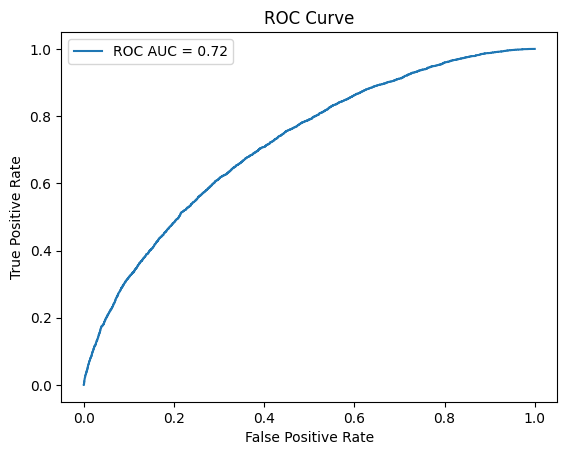

In [39]:
# Logistic Regression original
lr_model, lr_score, lr_f1, lr_mf1, lr_auc = logReg(X_train_scaled, y_train, X_test_scaled, y_test)

#Cross Validation mean score  for f1
lr_score_mean = lr_score.mean()
lr_score_std = lr_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.65998799 0.65592696 0.65334485 0.65821539 0.65548678]
Average f1: 0.66

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     16801
           1       0.33      0.65      0.44      4310

    accuracy                           0.66     21111
   macro avg       0.61      0.66      0.60     21111
weighted avg       0.77      0.66      0.69     21111



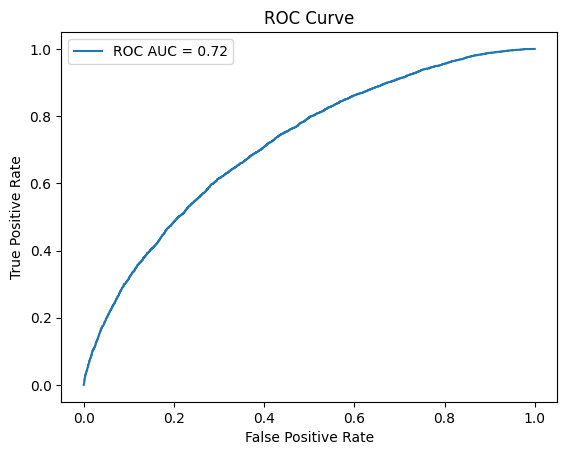

In [40]:
# Logistic Regression SMOTE
lrSM_model, lrSM_score, lrSM_f1, lrSM_mf1, lrSM_auc = logReg(X_smote, y_smote, X_test_scaled, y_test)

lrSM_score_mean = lrSM_score.mean()
lrSM_score_std = lrSM_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.64754829 0.65773985 0.66107185 0.66034942 0.65116963]
Average f1: 0.66

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.88      0.68      0.76     16801
           1       0.34      0.64      0.44      4310

    accuracy                           0.67     21111
   macro avg       0.61      0.66      0.60     21111
weighted avg       0.77      0.67      0.70     21111



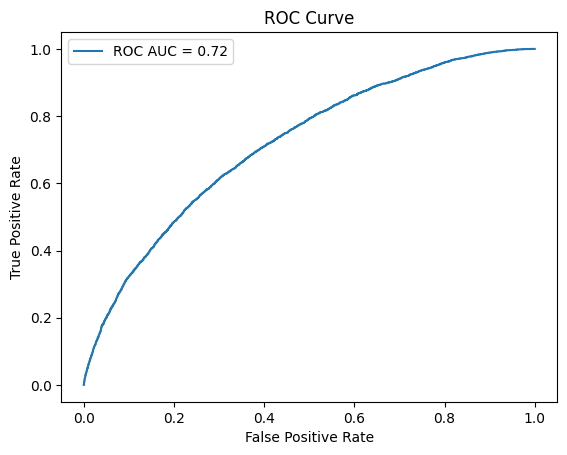

In [41]:
# Logistic Regression Undersampling
lrUNS_model, lrUNS_score, lrUNS_f1, lrUNS_mf1, lrUNS_auc = logReg(X_undersampled, y_undersampled, X_test_scaled, y_test)

lrUNS_score_mean = lrUNS_score.mean()
lrUNS_score_std = lrUNS_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.61732283 0.59330346 0.58266378 0.7853891  0.84754147]
Average f1: 0.69

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     16801
           1       0.36      0.56      0.44      4310

    accuracy                           0.70     21111
   macro avg       0.61      0.65      0.62     21111
weighted avg       0.76      0.70      0.73     21111



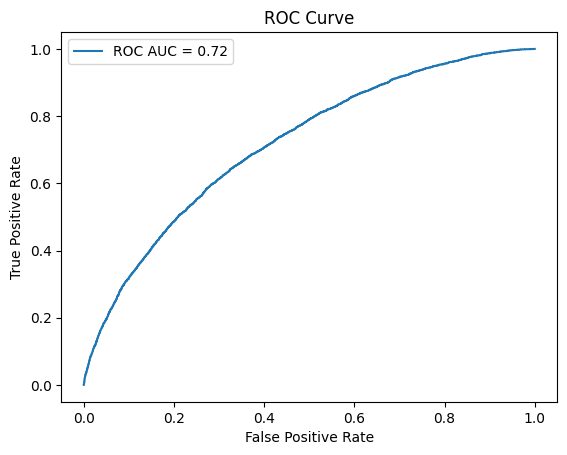

In [42]:
# Logistic Regression SVM SMOTE
lrSVMSM_model, lrSVMSM_score, lrSVMSM_f1, lrSVMSM_mf1, lrSVMSM_auc = logReg(X_smotesvm, y_smotesvm, X_test_scaled, y_test)

lrSVMSM_score_mean = lrSVMSM_score.mean()
lrSVMSM_score_std = lrSVMSM_score.std()

### Random Forest Classifier

In [43]:
def randomForest(X_train_scaled, y_train, X_test_scaled, y_test):
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
     
    # === Perform 5-fold cross validation on training data with  ===
    print("Training with 5-fold cross validation....")
    metric = 'f1'
    scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring=metric)
    print(f"{metric} across folds:", scores)
    print(f"Average {metric}: {scores.mean():.2f}\n")
    
    # === Evaluation on test data===
    rf_pred = rf_model.predict(X_test_scaled)
    print("Logistic Regression Classification Report on Test data: \n")
    print(classification_report(y_test, rf_pred))

    rf_f1 = f1_score(y_test, rf_pred)
    rf_mf1 = f1_score(y_test, rf_pred, average='macro')
    rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:,1])

    fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:,1])
    plt.plot(fpr, tpr, label=f"ROC AUC = {rf_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    return rf_model, scores, rf_f1, rf_mf1, rf_auc

Training with 5-fold cross validation....
f1 across folds: [0.28532556 0.28565899 0.30259589 0.29457066 0.28991597]
Average f1: 0.29

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     16801
           1       0.42      0.23      0.30      4310

    accuracy                           0.78     21111
   macro avg       0.62      0.58      0.59     21111
weighted avg       0.74      0.78      0.75     21111



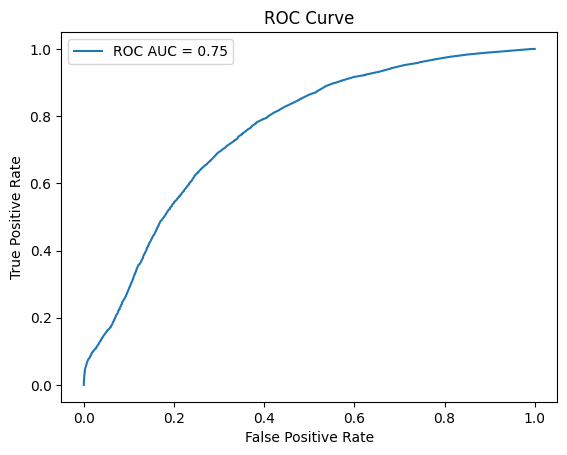

In [44]:
# Random Forest original
rf_model, rf_score, rf_f1, rf_mf1, rf_auc = randomForest(X_train_scaled, y_train, X_test_scaled, y_test)

#Cross Validation mean score  for f1
rf_score_mean = rf_score.mean()
rf_score_std = rf_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.59362024 0.86003181 0.92581311 0.92627083 0.92394111]
Average f1: 0.85

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     16801
           1       0.42      0.35      0.39      4310

    accuracy                           0.77     21111
   macro avg       0.63      0.62      0.62     21111
weighted avg       0.76      0.77      0.76     21111



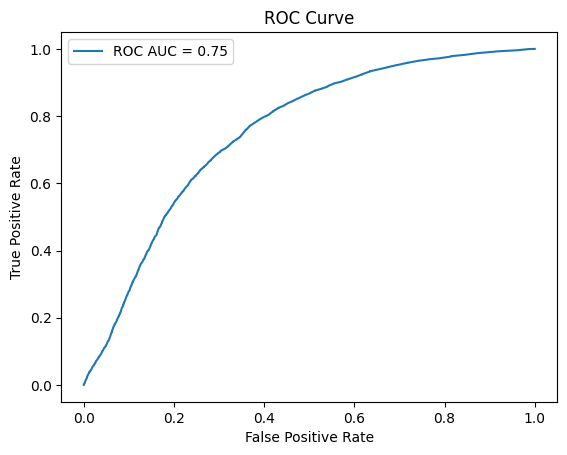

In [45]:
# Random Forest SMOTE
rfSM_model, rfSM_score, rfSM_f1, rfSM_mf1, rfSM_auc = randomForest(X_smote, y_smote, X_test_scaled, y_test)

rfSM_score_mean = rfSM_score.mean()
rfSM_score_std = rfSM_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.66901719 0.66410975 0.69257642 0.68678246 0.66910688]
Average f1: 0.68

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.89      0.69      0.77     16801
           1       0.35      0.67      0.46      4310

    accuracy                           0.68     21111
   macro avg       0.62      0.68      0.62     21111
weighted avg       0.78      0.68      0.71     21111



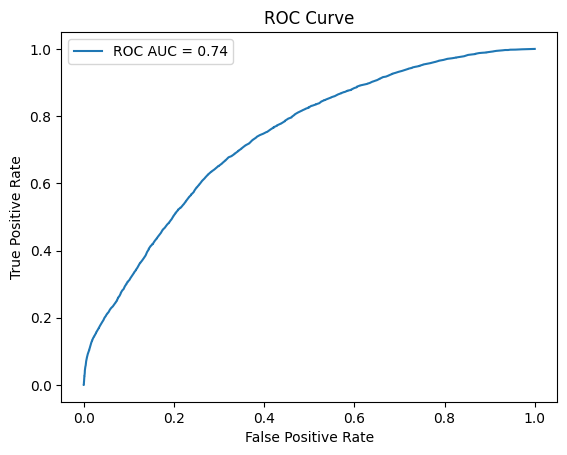

In [46]:
# Random Forest Undersampling
rfUNS_model, rfUNS_score, rfUNS_f1, rfUNS_mf1, rfUNS_auc = randomForest(X_undersampled, y_undersampled, X_test_scaled, y_test)

rfUNS_score_mean = rfUNS_score.mean()
rfUNS_score_std = rfUNS_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.55838641 0.83482003 0.91326329 0.93170049 0.93220045]
Average f1: 0.83

Logistic Regression Classification Report on Test data: 

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     16801
           1       0.42      0.34      0.38      4310

    accuracy                           0.77     21111
   macro avg       0.63      0.61      0.62     21111
weighted avg       0.75      0.77      0.76     21111



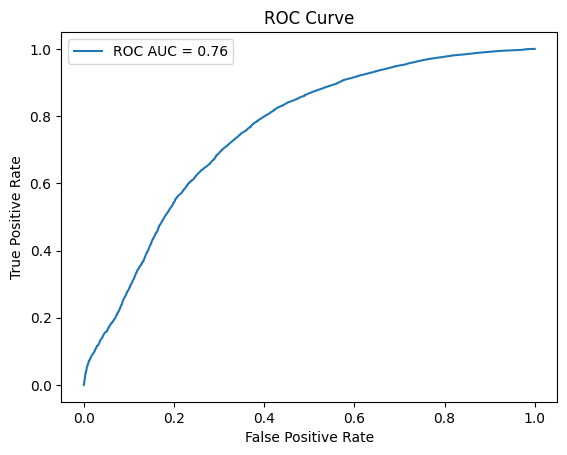

In [47]:
# Random Forest SVM SMOTE
rfSVMSM_model, rfSVMSM_score, rfSVMSM_f1, rfSVMSM_mf1, rfSVMSM_auc = randomForest(X_smotesvm, y_smotesvm, X_test_scaled, y_test)

rfSVMSM_score_mean = rfSVMSM_score.mean()
rfSVMSM_score_std = rfSVMSM_score.std()

### XGBoost Classifier

In [48]:
# === XGBoost Modeling ===
def xgb(X_train_scaled, y_train, X_test_scaled, y_test):
    xgb_model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42)

    xgb_model.fit(X_train_scaled, y_train)
    
    # === Perform 5-fold cross validation on training data with  ===
    print("Training with 5-fold cross validation....")
    metric = 'f1'
    scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring=metric)
    print(f"{metric} across folds:", scores)
    print(f"Average {metric}: {scores.mean():.2f}\n")
    

    # === Evaluation on Test data ===
    print("XGBoost Classification Report on Test data : \n")
    xgb_pred = xgb_model.predict(X_test_scaled)
    print(classification_report(y_test, xgb_pred))

    xgb_f1 = f1_score(y_test, xgb_pred)
    xgb_mf1 = f1_score(y_test, xgb_pred, average='macro')
    xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

    fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
    plt.plot(fpr, tpr, label=f"ROC AUC = {xgb_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    return xgb_model, scores, xgb_f1, xgb_mf1, xgb_auc

Training with 5-fold cross validation....
f1 across folds: [0.38416864 0.38866223 0.40305797 0.39405685 0.39854452]
Average f1: 0.39

XGBoost Classification Report on Test data : 

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     16801
           1       0.77      0.27      0.40      4310

    accuracy                           0.83     21111
   macro avg       0.80      0.62      0.65     21111
weighted avg       0.82      0.83      0.80     21111



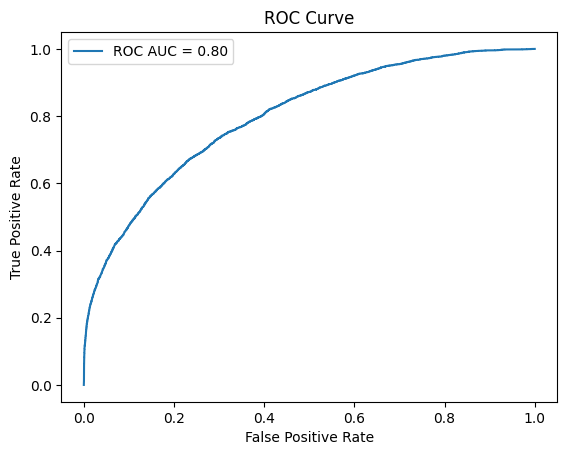

In [49]:
# XGBoost original
xgb_model, xgb_score, xgb_f1, xgb_mf1, xgb_auc = xgb(X_train_scaled, y_train, X_test_scaled, y_test)

#Cross Validation mean score  for f1
xgb_score_mean = xgb_score.mean()
xgb_score_std = xgb_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.21558544 0.85717809 0.95230396 0.95370677 0.9535501 ]
Average f1: 0.79

XGBoost Classification Report on Test data : 

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     16801
           1       0.68      0.30      0.42      4310

    accuracy                           0.83     21111
   macro avg       0.76      0.63      0.66     21111
weighted avg       0.81      0.83      0.80     21111



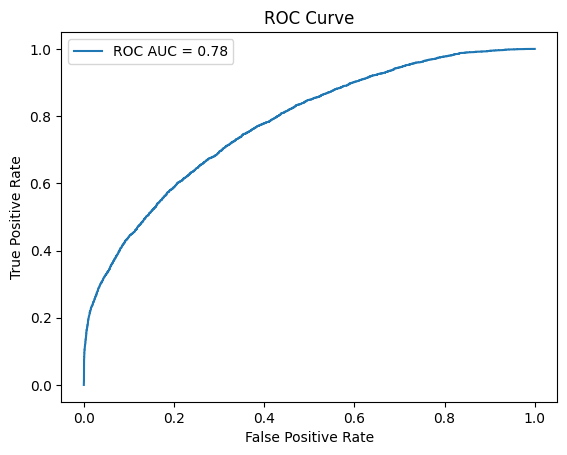

In [50]:
# XGBoost with SMOTE
xgbSM_model, xgbSM_score, xgbSM_f1, xgbSM_mf1, xgbSM_auc = xgb(X_smote, y_smote, X_test_scaled, y_test)

#Cross Validation mean score  for f1
xgbSM_score_mean = xgbSM_score.mean()
xgbSM_score_std = xgbSM_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.70586493 0.70371454 0.71363836 0.7176781  0.69927803]
Average f1: 0.71

XGBoost Classification Report on Test data : 

              precision    recall  f1-score   support

           0       0.90      0.72      0.80     16801
           1       0.40      0.70      0.51      4310

    accuracy                           0.72     21111
   macro avg       0.65      0.71      0.66     21111
weighted avg       0.80      0.72      0.74     21111



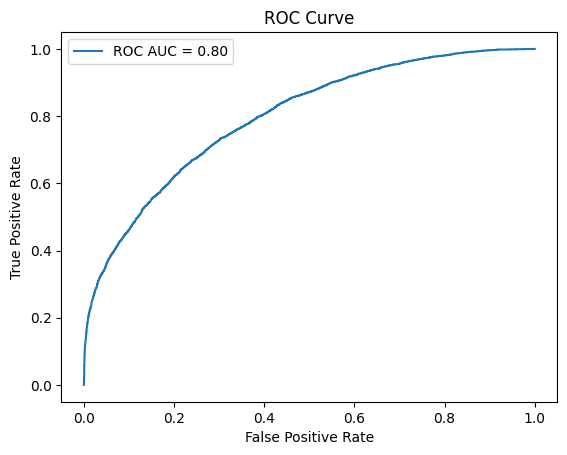

In [51]:
# XGBoost with Undersampling
xgbUNS_model, xgbUNS_score, xgbUNS_f1, xgbUNS_mf1, xgbUNS_auc = xgb(X_undersampled, y_undersampled, X_test_scaled, y_test)

#Cross Validation mean score  for f1
xgbUNS_score_mean = xgbUNS_score.mean()
xgbUNS_score_std = xgbUNS_score.std()

Training with 5-fold cross validation....
f1 across folds: [0.32319275 0.84073708 0.9302637  0.95789627 0.96544503]
Average f1: 0.80

XGBoost Classification Report on Test data : 

              precision    recall  f1-score   support

           0       0.85      0.95      0.89     16801
           1       0.61      0.32      0.42      4310

    accuracy                           0.82     21111
   macro avg       0.73      0.64      0.66     21111
weighted avg       0.80      0.82      0.80     21111



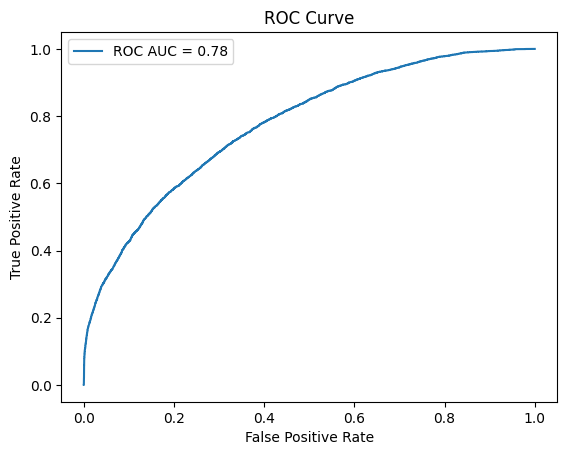

In [52]:
# XGBoost with SVM SMOTE
xgbSVMSM_model, xgbSVMSM_score, xgbSVMSM_f1, xgbSVMSM_mf1, xgbSVMSM_auc = xgb(X_smotesvm, y_smotesvm, X_test_scaled, y_test)

#Cross Validation mean score  for f1
xgbSVMSM_score_mean = xgbSVMSM_score.mean()
xgbSVMSM_score_std = xgbSVMSM_score.std()

## Model Selection 

### Comparing the performance of the 3 Models

1. Preformance of Training set while applying cross validation (CV)
2. Performance on Test set

### Cross-Validation: Evaluating Logistic Reg, Random Forest & XGBoost estimator's performance across sampling techniques

In [53]:
# === Multiple ROC Curves for Model Comparison ===
def plot_roc_curves(models, X_test, y_test):
    """
    Plot ROC curves for a list of models.
    models: list of tuples -> [("Model Name", model_object, predicted_probs)]
    """
    plt.figure(figsize=(8, 6))
    for name, model, probs in models:
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

In [54]:
#Model Performance - Train (CV) - Original Data
cv_df_original = pd.DataFrame({
    'Model': ['Logistic Regression (original)', 'Random Forest (original)', 'XGBoost (original)'],
    'F1-score (mean)': [lr_score_mean, rf_score_mean, xgb_score_mean ],
    'F1-score (std)': [lr_score_std, rf_score_std, xgb_score_std]})

cv_df_original['F1-score (mean)'] = cv_df_original['F1-score (mean)'].round(2)
cv_df_original['F1-score (std)'] = cv_df_original['F1-score (std)'].round(3)

#Model Performance - Train (CV) - SMOTE
cv_df_SM = pd.DataFrame({
    'Model': ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)'],
    'F1-score (mean)': [lrSM_score_mean, rfSM_score_mean, xgbSM_score_mean ],
    'F1-score (std)': [lrSM_score_std, rfSM_score_std, xgbSM_score_std]})

cv_df_SM['F1-score (mean)'] = cv_df_SM['F1-score (mean)'].round(2)
cv_df_SM['F1-score (std)'] = cv_df_SM['F1-score (std)'].round(3)

#Model Performance - Train (CV) - Undersampling
cv_df_UNS = pd.DataFrame({
    'Model': ['Logistic Regression (Undersampling)', 'Random Forest (Undersampling)', 'XGBoost (Undersampling)'],
    'F1-score (mean)': [lrUNS_score_mean, rfUNS_score_mean, xgbUNS_score_mean ],
    'F1-score (std)': [lrUNS_score_std, rfUNS_score_std, xgbUNS_score_std]})

cv_df_UNS['F1-score (mean)'] = cv_df_UNS['F1-score (mean)'].round(2)
cv_df_UNS['F1-score (std)'] = cv_df_UNS['F1-score (std)'].round(3)

#Model Performance - Train (CV) - SVM SMOTE
cv_df_SVMSM = pd.DataFrame({
    'Model': ['Logistic Regression (SVM SMOTE)', 'Random Forest (SVM SMOTE)', 'XGBoost (SVM SMOTE)'],
    'F1-score (mean)': [lrSVMSM_score_mean, rfSVMSM_score_mean, xgbSVMSM_score_mean ],
    'F1-score (std)': [lrSVMSM_score_std, rfSVMSM_score_std, xgbSVMSM_score_std]})

cv_df_SVMSM['F1-score (mean)'] = cv_df_SVMSM['F1-score (mean)'].round(2)
cv_df_SVMSM['F1-score (std)'] = cv_df_SVMSM['F1-score (std)'].round(3)

In [55]:
#Model Performance - Original Data
model_test_original = pd.DataFrame({
    'Model': ['Logistic Regression (original)', 'Random Forest (original)', 'XGBoost (original)'],
    'F1-score': [lr_f1, rf_f1, xgb_f1],
    'Macro_F1-score': [lr_mf1, rf_mf1, xgb_mf1],
    'ROC AUC': [lr_auc, rf_auc, xgb_auc]})

#Model Performance - SMOTE
model_test_SM = pd.DataFrame({
    'Model': ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)'],
    'F1-score': [lrSM_f1, rfSM_f1, xgbSM_f1],
    'Macro_F1-score': [lrSM_mf1, rfSM_mf1, xgbSM_mf1],
    'ROC AUC': [lrSM_auc, rfSM_auc, xgbSM_auc]})

#Model Performance - Undersampling
model_test_UNS = pd.DataFrame({
    'Model': ['Logistic Regression (Undersampling)', 'Random Forest (Undersampling)', 'XGBoost (Undersampling)'],
    'F1-score': [lrUNS_f1, rfUNS_f1, xgbUNS_f1],
    'Macro_F1-score': [lrUNS_mf1, rfUNS_mf1, xgbUNS_mf1],
    'ROC AUC': [lrUNS_auc, rfUNS_auc, xgbUNS_auc]})


#Model Performance - SVM SMOTE
model_test_SVMSM = pd.DataFrame({
    'Model': ['Logistic Regression (SVM SMOTE)', 'Random Forest (SVM SMOTE)', 'XGBoost (SVM SMOTE)'],
    'F1-score': [lrSVMSM_f1, rfSVMSM_f1, xgbSVMSM_f1],
    'Macro_F1-score': [lrSVMSM_mf1, rfSVMSM_mf1, xgbSVMSM_mf1],
    'ROC AUC': [lrSVMSM_auc, rfSVMSM_auc, xgbSVMSM_auc]})

## Plot - Model Performance Comparison with Sampling Technique (Traning data (Cross Validation))

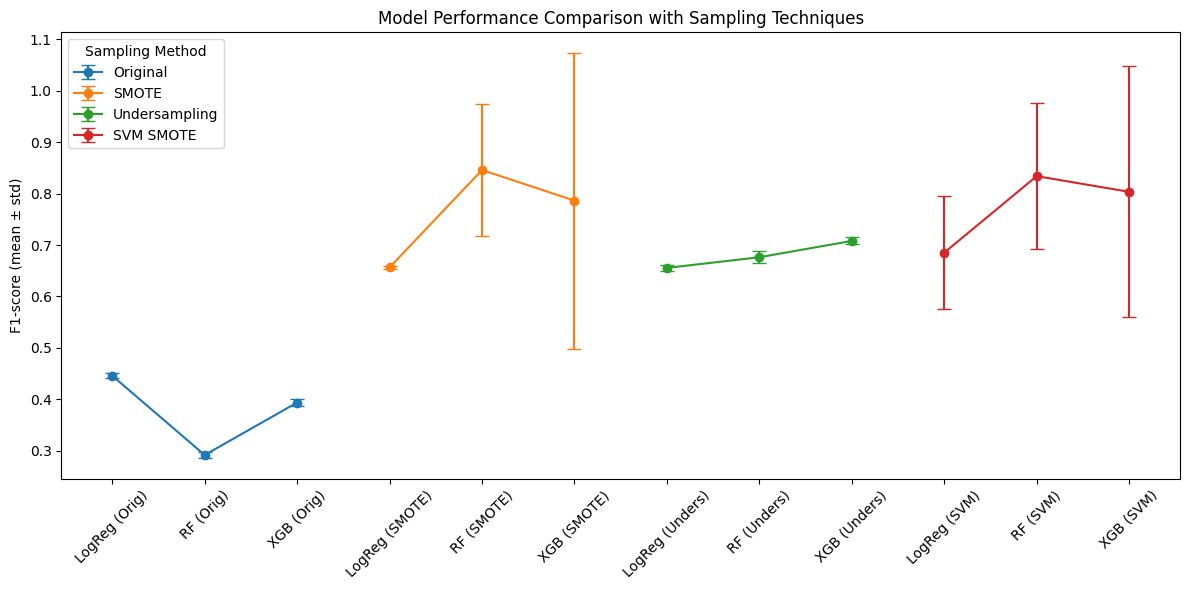

In [56]:
# === Plot Model F1-score Comparison ===
import matplotlib.pyplot as plt

# Define model data
plot_data = {
    'Model': [
        'LogReg (Orig)', 'RF (Orig)', 'XGB (Orig)',
        'LogReg (SMOTE)', 'RF (SMOTE)', 'XGB (SMOTE)',
        'LogReg (Unders)', 'RF (Unders)', 'XGB (Unders)',
        'LogReg (SVM)', 'RF (SVM)', 'XGB (SVM)'
    ],
    'F1-score': [lr_score_mean, rf_score_mean, xgb_score_mean, lrSM_score_mean, rfSM_score_mean, xgbSM_score_mean, lrUNS_score_mean, rfUNS_score_mean, xgbUNS_score_mean, lrSVMSM_score_mean, rfSVMSM_score_mean, xgbSVMSM_score_mean],
    'F1-std': [lr_score_std, rf_score_std, xgb_score_std, lrSM_score_std, rfSM_score_std, xgbSM_score_std, lrUNS_score_std, rfUNS_score_std, xgbUNS_score_std, lrSVMSM_score_std, rfSVMSM_score_std, xgbSVMSM_score_std],
    'Group': [
        'Original', 'Original', 'Original',
        'SMOTE', 'SMOTE', 'SMOTE',
        'Undersampling', 'Undersampling', 'Undersampling',
        'SVM SMOTE', 'SVM SMOTE', 'SVM SMOTE'
    ]
}

plot_df = pd.DataFrame(plot_data)
plt.figure(figsize=(12, 6))
for group in plot_df['Group'].unique():
    subset = plot_df[plot_df['Group'] == group]
    plt.errorbar(subset['Model'], subset['F1-score'], yerr=subset['F1-std'], fmt='o-', capsize=5, label=group)

plt.xticks(rotation=45)
plt.ylabel('F1-score (mean ± std)')
plt.title('Model Performance Comparison with Sampling Techniques')
plt.legend(title='Sampling Method')
plt.tight_layout()
plt.savefig("visualizations_2/model_families_performance_training_CV.png")
plt.show()

### Performance on Training data (Cross Validation - KFold (k =5))

In [57]:
# Display Training (CV) performance side by side
display_side_by_side(cv_df_original, cv_df_UNS, cv_df_SM, cv_df_SVMSM)

Model 
 F1-score (mean) 
 F1-score (std) 
 
 
 
 
 0 
 Logistic Regression (original) 
 0.45 
 0.005 
 
 
 1 
 Random Forest (original) 
 0.29 
 0.006 
 
 
 2 
 XGBoost (original) 
 0.39 
 0.007 
 
 
 
 
 
 
 Model 
 F1-score (mean) 
 F1-score (std) 
 
 
 
 
 0 
 Logistic Regression (Undersampling) 
 0.66 
 0.005 
 
 
 1 
 Random Forest (Undersampling) 
 0.68 
 0.011 
 
 
 2 
 XGBoost (Undersampling) 
 0.71 
 0.007 
 
 
 
 
 
 
 Model 
 F1-score (mean) 
 F1-score (std) 
 
 
 
 
 0 
 Logistic Regression (SMOTE) 
 0.66 
 0.002 
 
 
 1 
 Random Forest (SMOTE) 
 0.85 
 0.129 
 
 
 2 
 XGBoost (SMOTE) 
 0.79 
 0.288 
 
 
 
 
 
 
 Model 
 F1-score (mean) 
 F1-score (std) 
 
 
 
 
 0 
 Logistic Regression (SVM SMOTE) 
 0.69 
 0.110 
 
 
 1 
 Random Forest (SVM SMOTE) 
 0.83 
 0.142 
 
 
 2 
 XGBoost (SVM SMOTE) 
 0.80 
 0.244

### Performance on Test data

Model 
 F1-score 
 Macro_F1-score 
 ROC AUC 
 
 
 
 
 0 
 Logistic Regression (original) 
 0.44 
 0.60 
 0.72 
 
 
 1 
 Random Forest (original) 
 0.30 
 0.59 
 0.75 
 
 
 2 
 XGBoost (original) 
 0.40 
 0.65 
 0.80 
 
 
 
 
 
 
 Model 
 F1-score 
 Macro_F1-score 
 ROC AUC 
 
 
 
 
 0 
 Logistic Regression (Undersampling) 
 0.44 
 0.60 
 0.72 
 
 
 1 
 Random Forest (Undersampling) 
 0.46 
 0.62 
 0.74 
 
 
 2 
 XGBoost (Undersampling) 
 0.51 
 0.66 
 0.80 
 
 
 
 
 
 
 Model 
 F1-score 
 Macro_F1-score 
 ROC AUC 
 
 
 
 
 0 
 Logistic Regression (SMOTE) 
 0.44 
 0.60 
 0.72 
 
 
 1 
 Random Forest (SMOTE) 
 0.39 
 0.62 
 0.75 
 
 
 2 
 XGBoost (SMOTE) 
 0.42 
 0.66 
 0.78 
 
 
 
 
 
 
 Model 
 F1-score 
 Macro_F1-score 
 ROC AUC 
 
 
 
 
 0 
 Logistic Regression (SVM SMOTE) 
 0.44 
 0.62 
 0.72 
 
 
 1 
 Random Forest (SVM SMOTE) 
 0.38 
 0.62 
 0.76 
 
 
 2 
 XGBoost (SVM SMOTE) 
 0.42 
 0.66 
 0.78

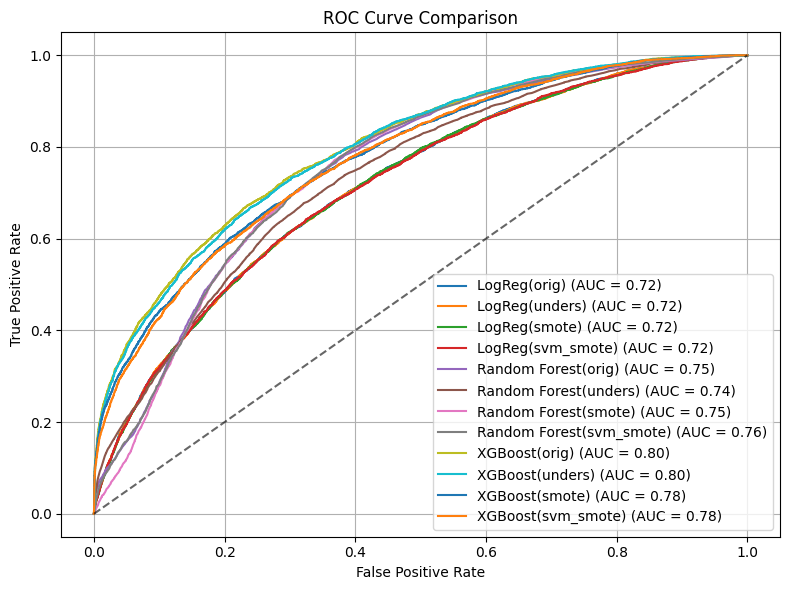

In [58]:
display_side_by_side(model_test_original.round(2), model_test_UNS.round(2), model_test_SM.round(2), model_test_SVMSM.round(2))

plot_roc_curves([
    ("LogReg(orig)", lr_model, lr_model.predict_proba(X_test_scaled)[:, 1]),
    ("LogReg(unders)", lrUNS_model, lrUNS_model.predict_proba(X_test_scaled)[:, 1]),
    ("LogReg(smote)", lrSM_model, lrSM_model.predict_proba(X_test_scaled)[:, 1]),
    ("LogReg(svm_smote)", lrSVMSM_model, lrSVMSM_model.predict_proba(X_test_scaled)[:, 1]),
    ("Random Forest(orig)", rf_model, rf_model.predict_proba(X_test_scaled)[:, 1]),
    ("Random Forest(unders)", rfUNS_model, rfUNS_model.predict_proba(X_test_scaled)[:, 1]),
    ("Random Forest(smote)", rfSM_model, rfSM_model.predict_proba(X_test_scaled)[:, 1]),
    ("Random Forest(svm_smote)", rfSVMSM_model, rfSVMSM_model.predict_proba(X_test_scaled)[:, 1]),
    ("XGBoost(orig)", xgb_model, xgb_model.predict_proba(X_test_scaled)[:, 1]),
    ("XGBoost(unders)", xgbUNS_model, xgbUNS_model.predict_proba(X_test_scaled)[:, 1]),
    ("XGBoost(smote)", xgbSM_model, xgbSM_model.predict_proba(X_test_scaled)[:, 1]),
    ("XGBoost(svm_smote)", xgbSVMSM_model, xgbSVMSM_model.predict_proba(X_test_scaled)[:, 1]),
], X_test_scaled, y_test)

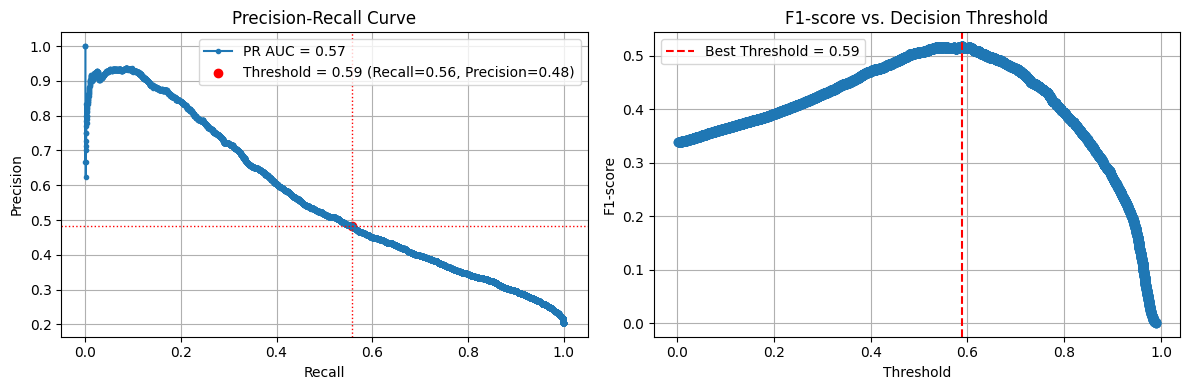

In [59]:
# === Precision-Recall Curve for Model Selected prior to Hyperparamater tuning ===
y_probs = xgbUNS_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# === Precision-Recall Curve and F1-score vs. Threshold ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Precision-Recall Curve
axes[0].plot(recall, precision, marker='.', label=f'PR AUC = {ap_score:.2f}')
axes[0].scatter(recall[best_idx], precision[best_idx], color='red', label=f'Threshold = {best_threshold:.2f} (Recall={recall[best_idx]:.2f}, Precision={precision[best_idx]:.2f})')
axes[0].axhline(precision[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].axvline(recall[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

# F1-score vs Threshold
axes[1].plot(thresholds, f1_scores, marker='o')
axes[1].axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-score')
axes[1].set_title('F1-score vs. Decision Threshold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("visualizations_2/pr_and_f1_threshold_before_tuning.png")
plt.show()

### Best Model Overall

**XGBoost with Undersampling (F1 = 0.71 ± 0.007)**
- Has the highest training F1-score (0.71) with low variance
- Generalizes well with a test F1 of 0.51 and ROC AUC of 0.80
- Shows only a ~0.20 drop from train to test (expected for real-world problems)
- Outperforms all other models in every evaluation metric

## Hyperparameter Tuning

In [83]:
%%time
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 5, 10]   # L2 regularization
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_undersampled, y_undersampled)

print(f"Best XGBoost Params : {grid_search.best_params_}")
print("Best XGBoost Score (CV score (F1)) : ", grid_search.best_score_)

xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best XGBoost Params : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 1.0}
Best XGBoost Score (CV score (F1)) :  0.7100940175445845
CPU times: user 4.12 s, sys: 1.77 s, total: 5.89 s
Wall time: 1min 32s


In [86]:
# y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
# ap_score = average_precision_score(y_test, y_probs)

XGBoost Classification Report : 

              precision    recall  f1-score   support

           0       0.91      0.73      0.81     16801
           1       0.40      0.71      0.51      4310

    accuracy                           0.73     21111
   macro avg       0.66      0.72      0.66     21111
weighted avg       0.80      0.73      0.75     21111



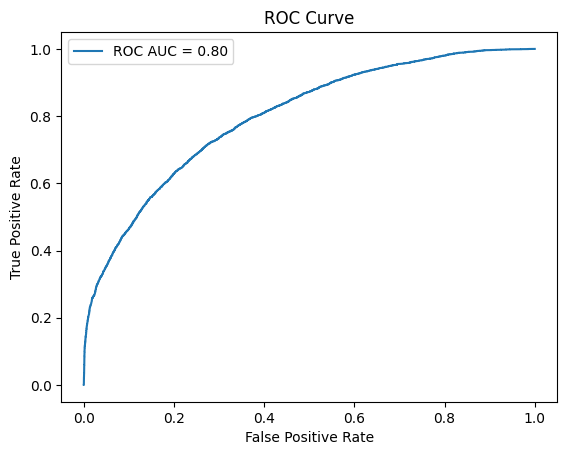

In [62]:
# === Evaluation (At the Default Threshold (>= 0.5) ===
xgb_model_pred = xgb_model.predict(X_test_scaled)
print("XGBoost Classification Report : \n")
print(classification_report(y_test, xgb_model_pred))

xgb_model_f1 = f1_score(y_test, xgb_model_pred)
xgb_model_mf1 = f1_score(y_test, xgb_model_pred, average='macro')
xgb_model_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {xgb_model_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Threshold Tuning

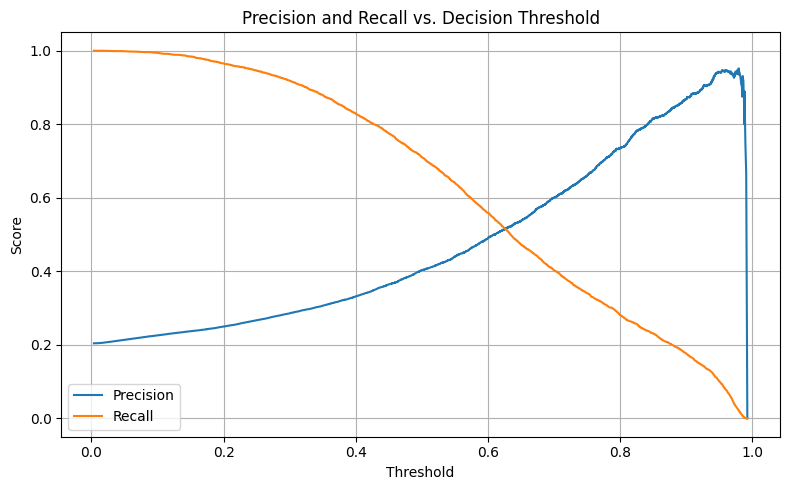

In [63]:
# === Threshold Tuning for Better Recall ===

# Precision-recall vs threshold plot
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("visualizations_2/precision_recall_vs_decision_threshold_tuning.png")
plt.show()

Best threshold for F1-score: 0.60
F1-score at best threshold: 0.52
Classification report at best F1 threshold:

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     16801
           1       0.49      0.56      0.52      4310

    accuracy                           0.79     21111
   macro avg       0.69      0.71      0.70     21111
weighted avg       0.80      0.79      0.80     21111



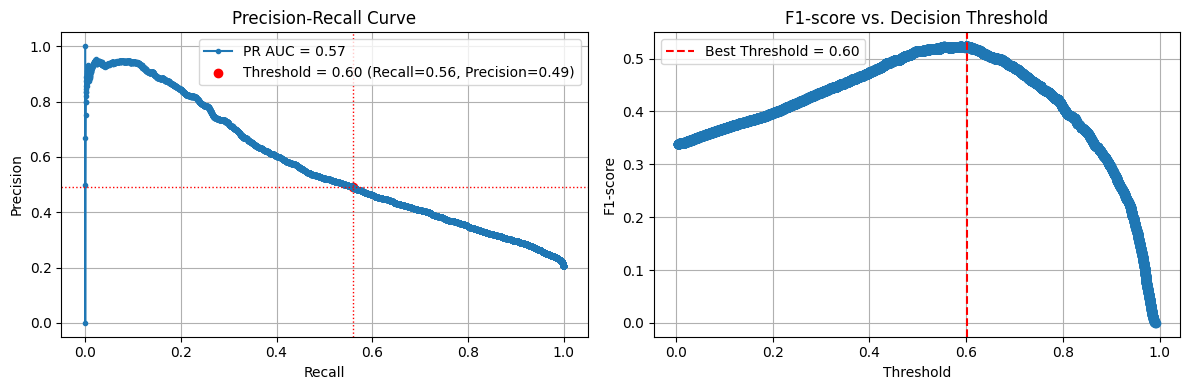

In [64]:
# === Optimal Threshold Based on F1-score ===
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1-score: {best_threshold:.2f}")
print(f"F1-score at best threshold: {f1_scores[best_idx]:.2f}")

y_pred_best = (y_probs >= best_threshold).astype(int)
print("Classification report at best F1 threshold:\n")
print(classification_report(y_test, y_pred_best))


# === Precision-Recall Curve and F1-score vs. Threshold ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Precision-Recall Curve
axes[0].plot(recall, precision, marker='.', label=f'PR AUC = {ap_score:.2f}')
axes[0].scatter(recall[best_idx], precision[best_idx], color='red', label=f'Threshold = {best_threshold:.2f} (Recall={recall[best_idx]:.2f}, Precision={precision[best_idx]:.2f})')
axes[0].axhline(precision[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].axvline(recall[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

# F1-score vs Threshold
axes[1].plot(thresholds, f1_scores, marker='o')
axes[1].axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-score')
axes[1].set_title('F1-score vs. Decision Threshold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("visualizations_2/pr_and_f1_threshold_after_tuning.png")
plt.show()

## Making predictions using the best threshold

Random Forest Classification Report at best F1 threshold:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     16801
           1       0.49      0.56      0.52      4310

    accuracy                           0.79     21111
   macro avg       0.69      0.71      0.70     21111
weighted avg       0.80      0.79      0.80     21111



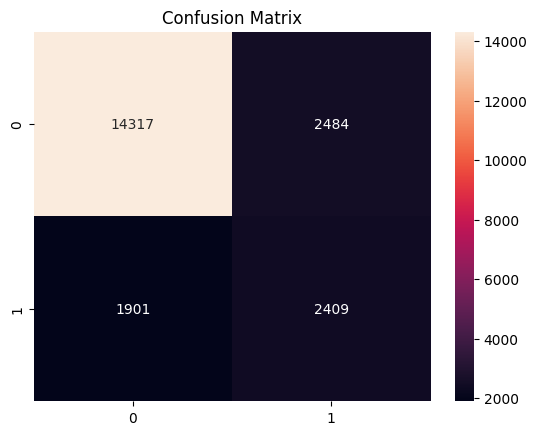

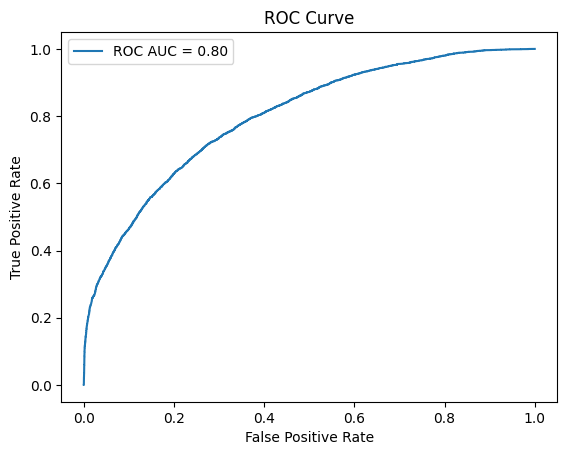

In [65]:
xgb_model_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_model_pred = (xgb_model_probs >= best_threshold).astype(int)
print("Random Forest Classification Report at best F1 threshold:")
print(classification_report(y_test, xgb_model_pred))
sns.heatmap(confusion_matrix(y_test, xgb_model_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

xgb_model_f1 = f1_score(y_test, xgb_model_pred)
xgb_model_mf1 = f1_score(y_test, xgb_model_pred, average='macro')
xgb_model_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {xgb_model_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Feature Importance

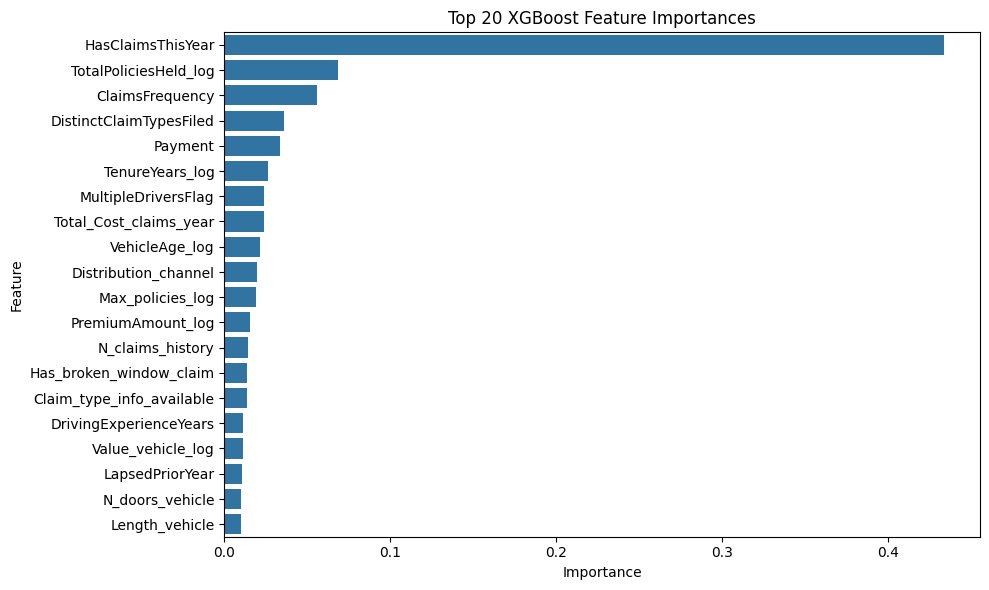

In [66]:
# === XGBoost Feature Importance ===
importances = xgb_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [67]:
# # Table of top 20 features based on Feature Importance api
# importance_df.sort_values(by='Importance', ascending=False).head(20)

## SHAP

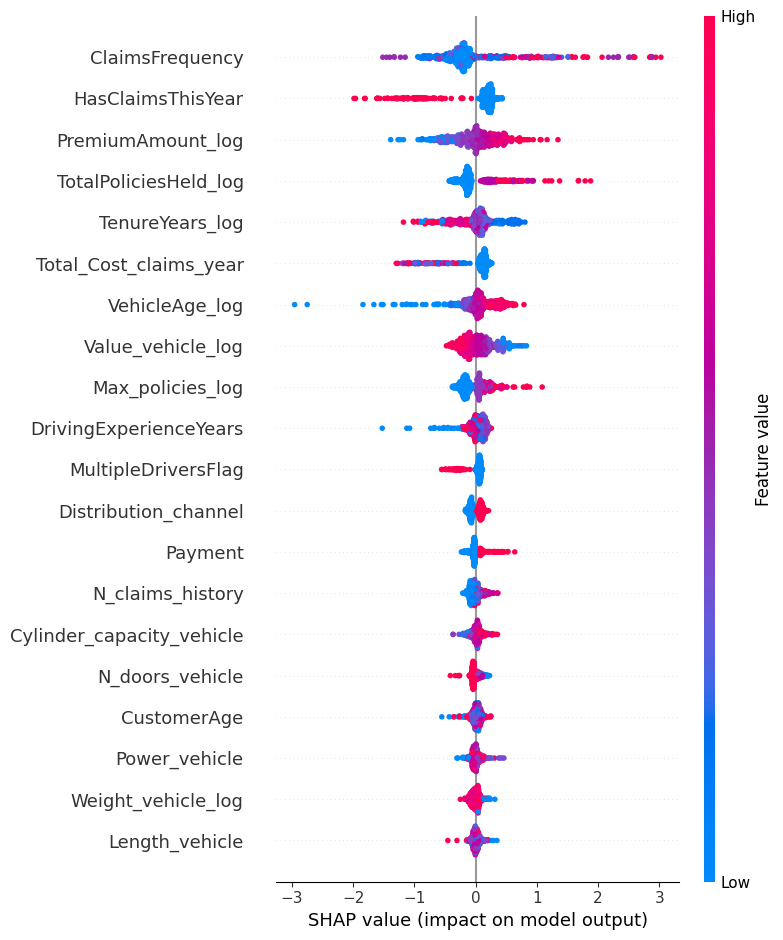

In [68]:
import shap
shap.initjs()

X_sample = X_test_scaled[:500]  # Limit for performance
explainer = shap.Explainer(xgb_model, X_sample)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=X.columns, show=False)
plt.tight_layout()
plt.savefig("visualizations_2/SHAP.png")
plt.show()

### Compare SHAP Values to Feature Importance

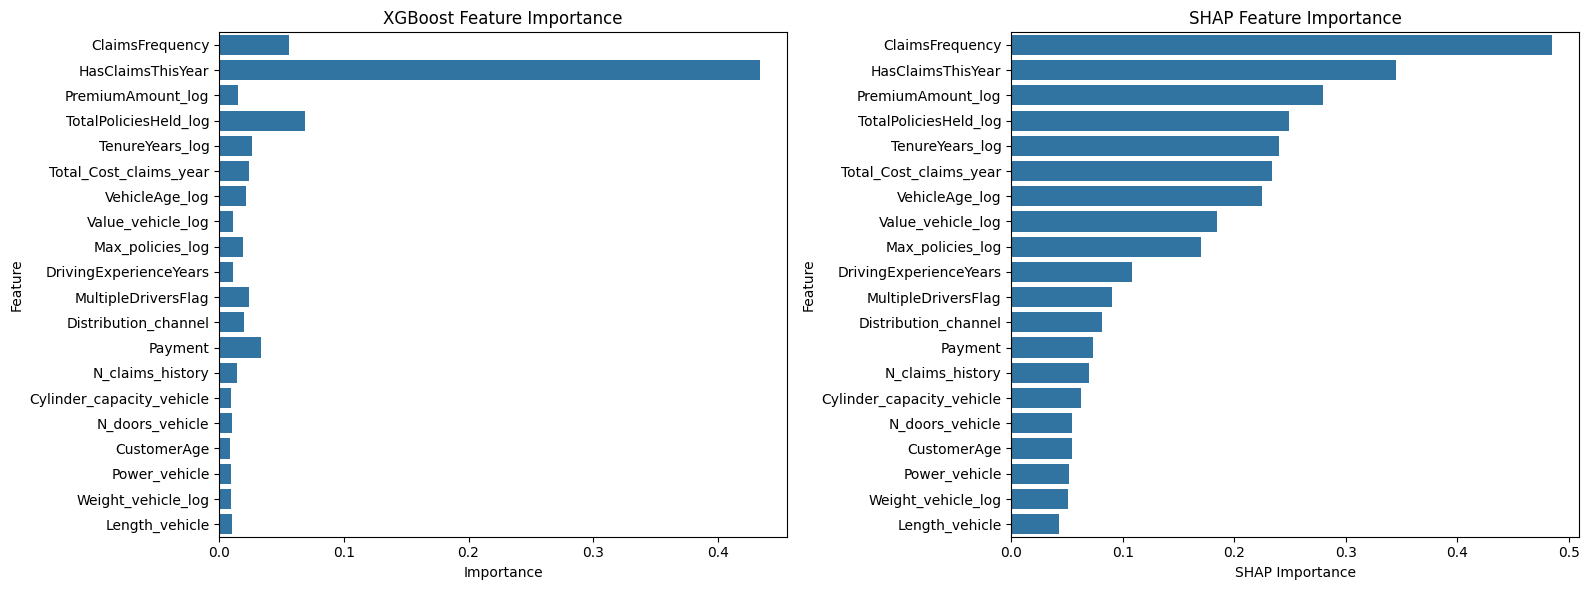

In [69]:
# === Combine SHAP and XGBoost Importances ===
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({'Feature': X.columns, 'SHAP Importance': shap_abs_mean})

comparison_df = importance_df.merge(shap_df, on='Feature', how='outer').fillna(0)
comparison_df = comparison_df.sort_values(by='SHAP Importance', ascending=False)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=comparison_df.head(20), x='Importance', y='Feature', ax=axes[0])
axes[0].set_title('XGBoost Feature Importance')
sns.barplot(data=comparison_df.head(20), x='SHAP Importance', y='Feature', ax=axes[1])
axes[1].set_title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig("visualizations_2/feature_importance_comparison.png")
plt.show()

In [70]:
#Table of top 20 features using SHAP
#shap_df.sort_values(by='SHAP Importance', ascending=False).head(30)

# Retrain using Top 20 variables from SHAP & Feature Importance consolidated table (Feature Selection)

In [71]:
X_new = X[comparison_df['Feature'].head(20).unique()]

In [72]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, test_size=0.2, random_state=42)

In [73]:
# === Scale ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

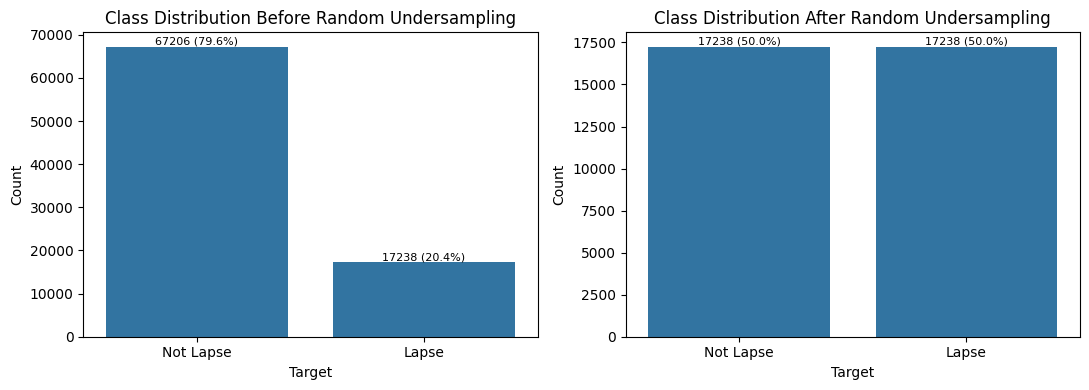

In [74]:
X_undersampled, y_undersampled = random_undersample(X_train_scaled, y_train)

In [75]:
grid_search.fit(X_undersampled, y_undersampled)

print(f"Best XGBoost Params : {grid_search.best_params_}")
print("Best XGBoost Score (CV score (F1)) : ", grid_search.best_score_)

xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best XGBoost Params : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 1.0}
Best XGBoost Score (CV score (F1)) :  0.7100940175445845


## Evaluation after Retraining with Top 20 Features

XGBoost Classification Report : 

              precision    recall  f1-score   support

           0       0.91      0.72      0.81     16801
           1       0.40      0.71      0.51      4310

    accuracy                           0.72     21111
   macro avg       0.65      0.72      0.66     21111
weighted avg       0.80      0.72      0.75     21111



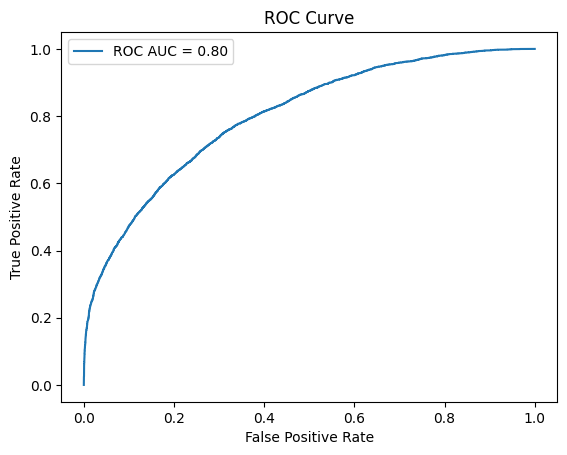

In [76]:
# === Evaluation (At the Default Threshold (>= 0.5) ===
xgb_model_pred = xgb_model.predict(X_test_scaled)
print("XGBoost Classification Report : \n")
print(classification_report(y_test, xgb_model_pred))

xgb_model_f1 = f1_score(y_test, xgb_model_pred)
xgb_model_mf1 = f1_score(y_test, xgb_model_pred, average='macro')
xgb_model_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {xgb_model_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

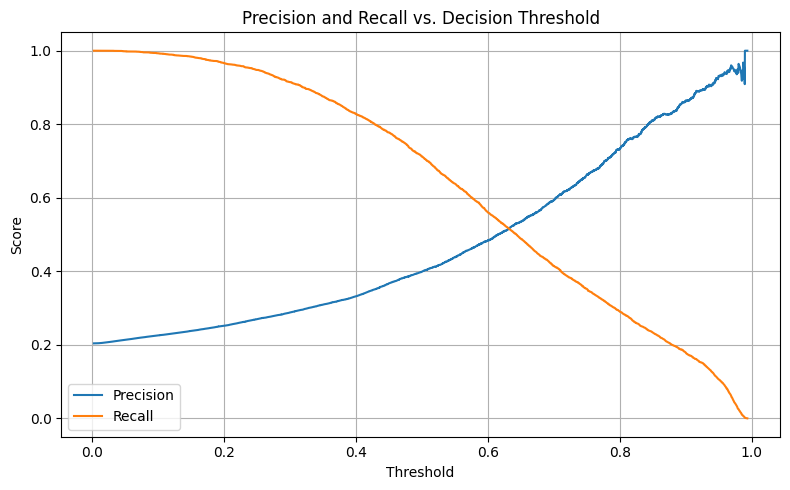

In [81]:
# === Threshold Tuning for Better Recall ===

# Precision-recall vs threshold plot
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("visualizations_2/precision_recall_vs_decision_threshold_tuning_top_20.png")
plt.show()

Best threshold for F1-score: 0.59
F1-score at best threshold: 0.52
Classification report at best F1 threshold:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     16801
           1       0.47      0.59      0.52      4310

    accuracy                           0.78     21111
   macro avg       0.68      0.71      0.69     21111
weighted avg       0.80      0.78      0.79     21111



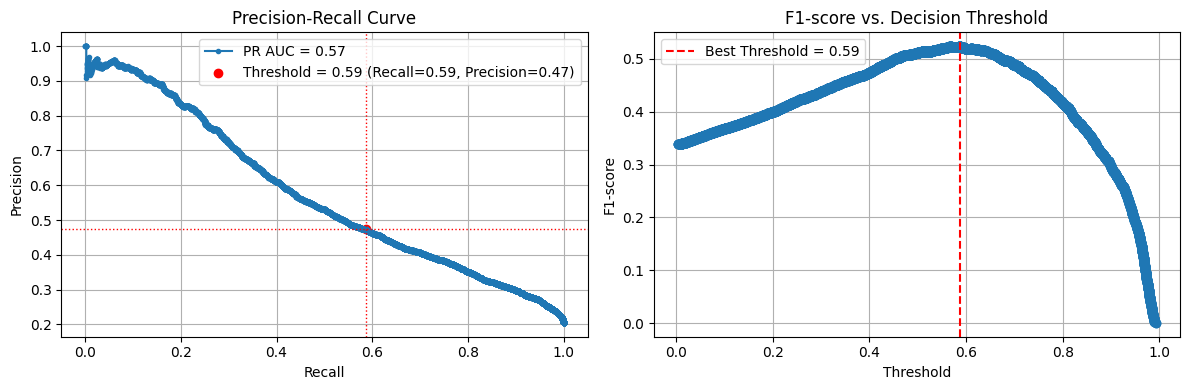

In [82]:
# === Optimal Threshold Based on F1-score ===
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1-score: {best_threshold:.2f}")
print(f"F1-score at best threshold: {f1_scores[best_idx]:.2f}")

y_pred_best = (y_probs >= best_threshold).astype(int)
print("Classification report at best F1 threshold:\n")
print(classification_report(y_test, y_pred_best))


# === Precision-Recall Curve and F1-score vs. Threshold ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Precision-Recall Curve
axes[0].plot(recall, precision, marker='.', label=f'PR AUC = {ap_score:.2f}')
axes[0].scatter(recall[best_idx], precision[best_idx], color='red', label=f'Threshold = {best_threshold:.2f} (Recall={recall[best_idx]:.2f}, Precision={precision[best_idx]:.2f})')
axes[0].axhline(precision[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].axvline(recall[best_idx], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True)

# F1-score vs Threshold
axes[1].plot(thresholds, f1_scores, marker='o')
axes[1].axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-score')
axes[1].set_title('F1-score vs. Decision Threshold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("visualizations_2/pr_and_f1_threshold_after_tuning_top_20.png")
plt.show()

Random Forest Classification Report at best F1 threshold:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     16801
           1       0.47      0.59      0.52      4310

    accuracy                           0.78     21111
   macro avg       0.68      0.71      0.69     21111
weighted avg       0.80      0.78      0.79     21111



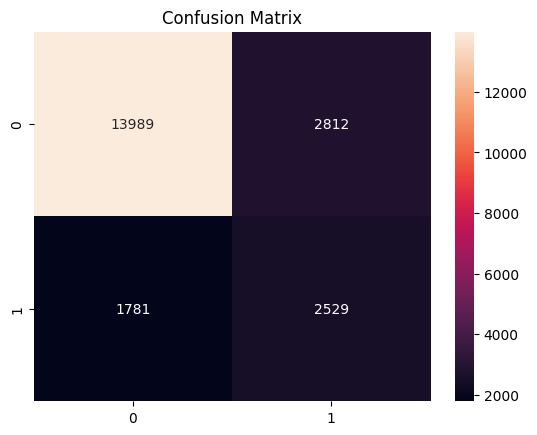

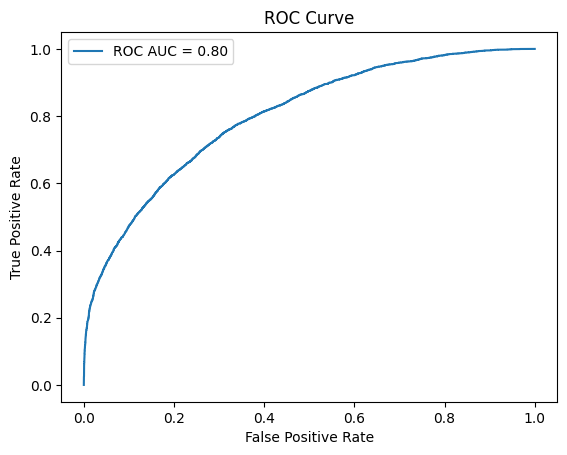

In [80]:
xgb_model_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_model_pred = (xgb_model_probs >= best_threshold).astype(int)
print("Random Forest Classification Report at best F1 threshold:")
print(classification_report(y_test, xgb_model_pred))
sns.heatmap(confusion_matrix(y_test, xgb_model_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

xgb_model_f1 = f1_score(y_test, xgb_model_pred)
xgb_model_mf1 = f1_score(y_test, xgb_model_pred, average='macro')
xgb_model_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

fpr, tpr, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr, label=f"ROC AUC = {xgb_model_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Result

After retraining with Top 20 Features, the XGBoost model saw an increase in its Recall score from 0.57 to 0.59, a decrease in the Precision from 0.49 to 0.47. This shows that the model is able to identify the positive class (reducing false negatives) while still maintaining some balance between false positives and false negatives.

**Interpretation**
1. Recall ↑ (0.57 → 0.59)
The XGBoost model is now catching more of the actual positive cases (i.e., identifying more lapses).

2. Precision ↓ (0.49 → 0.47)
But it's doing that at the cost of making more false positive predictions — predicting more people will lapse when they actually don’t.

3. F1-score unchanged
Which means the increase in recall and drop in precision balance out mathematically in the F1-score equation:

F1 = (2 * Precision * Recall)/(Precision + Recall)

 So even though individual components shifted, their combined trade-off remained constant.